# LIBRARIES

In [1]:
%config IPCompleter.greedy=True
import warnings
warnings.filterwarnings('ignore')

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [3]:
# Importação de Bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.dates as mdates
%matplotlib inline
import psycopg2
from scipy import stats
import glob
import math
from numba import jit

from pylab import rcParams
import statsmodels.api as sm

import plotly.express as px
import ipywidgets as widgets
from ipywidgets import fixed
import folium
from folium.map import Layer, FeatureGroup,LayerControl,Marker
from folium.plugins import MarkerCluster,FeatureGroupSubGroup,Fullscreen

# Configuração para exibir todas as colunas
pd.set_option('display.max_columns', None)
# Configuração de exibição numérica
pd.options.display.float_format = '{:.2f}'.format

In [4]:
# DATAWAREHOUSE

import sys

#sys.path.insert(1, '//BRNEP219/Analytics/')
sys.path.insert(1, '//10.219.90.42/Analytics/')
from utils.base_dados.sql_server.conexao_bd_sql import *



# FUNÇÕES

### PLOTS GERAIS

In [5]:
# Pareto Plot
def plot_pareto(title, dataframe, axis_x, axis_y,var='soma'):
    fig,axes = plt.subplots(1,1,figsize=(17,10))
    plt.title(title, style='italic',fontsize=15)
    df = dataframe.copy()
    
    if axis_x == axis_y:
        axis_y = axis_y + '2'
        df[axis_y] = df[axis_x]
    
    if var == 'soma':
        df = df.groupby(axis_x, as_index = False)[axis_y].sum()
    else:
        df = df.groupby(axis_x, as_index = False)[axis_y].count()
    df = df.sort_values(axis_y, ascending = False)
    df['PARETO'] = round(100*df[axis_y].cumsum()/df[axis_y].sum(),2)
    ax = sns.barplot(x = axis_x, y = axis_y, data = df, palette=("Reds_d"))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=65, horizontalalignment='right') 
    
    for p in ax.patches:
        # get the height of each bar
        height = p.get_height()
        # adding text to each bar
        ax.text(x = p.get_x()+(p.get_width()/2), # x-coordinate position of data label, padded to be in the middle of the bar
        rotation = 0,
        y = height + (height/100), # y-coordinate position of data label, padded 100 above bar
        s = '{:.0f}'.format(height), # data label, formatted to ignore decimals
        ha = 'center',fontsize=13) # sets horizontal alignment (ha) to center
    ax2 = ax.twinx()
    ax2.plot(df[axis_x], df['PARETO'], color="C1", marker="D")
    ax2.set_ylim([0,105])
    plt.axhline(80,color='r',linestyle='--')
    #ax2.yaxis.set_major_formatter(PercentFormatter())
    plt.show()

### EXPORT R

In [6]:
def export_base_R(df,caminho,nome_arquivo):
    df = df.sort_values('DT_ABREVIADA',ascending = True)
    d = pd.DataFrame()
    for i in df['DT_ABREVIADA'].unique():
        # total
        dd = df.loc[df['DT_ABREVIADA'] == i]
        dd = dd.groupby(['DT_ABREVIADA'],as_index = False)['OC_ID'].count()

        # improd
        dd1 = df.loc[(df['DT_ABREVIADA'] == i)&(df['DSES'] == 'S')]
        dd1 = dd1.groupby(['DT_ABREVIADA'],as_index = False)['OC_ID'].count()

        dd2 = pd.concat([dd,dd1['OC_ID']], axis = 1 ,ignore_index = True)

        d = pd.concat([d,dd2], axis = 0 ,ignore_index = True)
    d = d.reset_index(drop = True)
    d.columns = ['DT_ABREVIADA','OC_ID','IMPRODUTIVO']
    d['PCT'] = round( 100 * d['IMPRODUTIVO']/d['OC_ID'],1)

    df = d.copy()

    df.to_csv(caminho + nome_arquivo,index = False)
    return None

### TRANSFORMAÇÕES GERAIS

In [7]:
@jit(nopython=False)
def transformar_noxnoy_latlon(df,nx,ny):
    nox = df[nx].values
    noy = df[ny].values
    latitude = []
    longitude = []
    df = df.reset_index(drop = True)
    for i in df.index:
        lat,lon = converter_utm_latlong(nox[i],noy[i],'S','SGD',22)
        latitude.append(lat)
        longitude.append(lon)

    df['LATITUDE'] = latitude
    df['LONGITUDE'] = longitude
    return df

@jit(nopython = True)
def converter_utm_latlong(CoordenadaX,CoordenadaY,NS,SGD,zona):
    #(CoordenadaX nox, CoordenadaY noy, NS 'S', SGD 'N', zona '22', Retorno 'lat') 
    a = 6378137 #Raio Equatorial
    b = 6356752.314 #Eixo Polar
    e = 0.081819191 #Achatamento
    eisq = 0.006739497 #Achatamento²
    k0 = 0.9996 #Fator de Escala

    #Based Constants
    ei = (1 - (1 - e * e) ** (1 / 2)) / (1 + (1 - e * e) ** (1 / 2))
    C1 = 3 * ei / 2 - 27 * ei ** 3 / 32
    C2 = 21 * ei ** 2 / 16 - 55 * ei ** 4 / 32
    C3 = 151 * ei ** 3 / 96
    C4 = 1097 * ei ** 4 / 512

    #Formula Constant
    PI = 3.14159265358979
    sino1 = 4.84813681109536E-06

    if (NS == "N"): 
        CorrectedNorthing = CoordenadaY
    else:
        CorrectedNorthing = 10000000 - CoordenadaY
   
    
    if SGD == "S":

        if CoordenadaX > 840000:
            CoordenadaX = CoordenadaX - 608000
            zona = 23
        else:
            CoordenadaX = CoordenadaX
            zona = 22

    EastPrime = 500000 - CoordenadaX
    ArcLength = CorrectedNorthing / k0
    mu = ArcLength / (a * (1 - e ** 2 / 4 - 3 * e ** 4 / 64 - 5 * e ** 6 / 256))
    phi = mu + C1 * math.sin(2 * mu) + C2 * math.sin(4 * mu) + C3 * math.sin(6 * mu) + C4 * math.sin(8 * mu)
    C1_ = eisq * math.cos(phi) ** 2
    T1_ = math.tan(phi) ** 2
    N1_ = a / (1 - (e * math.sin(phi)) ** 2) ** (1 / 2)
    R1_ = a * (1 - e * e) / (1 - (e * math.sin(phi)) ** 2) ** (3 / 2)
    D = EastPrime / (N1_ * k0)
    Fact1 = N1_ * math.tan(phi) / R1_
    Fact2 = D * D / 2
    Fact3 = (5 + 3 * T1_ + 10 * C1_ - 4 * C1_ * C1_ - 9 * eisq) * D ** 4 / 24
    Fact4 = (61 + 90 * T1_ + 298 * C1_ + 45 * T1_ * T1_ - 252 * eisq - 3 * C1_ * C1_) * D ** 6 / 720
    LoFact1 = D
    LoFact2 = (1 + 2 * T1_ + C1_) * D ** 3 / 6
    LoFact3 = (5 - 2 * C1_ + 28 * T1_ - 3 * C1_ ** 2 + 8 * eisq + 24 * T1_ ** 2) * D ** 5 / 120
    Delta_Long = (LoFact1 - LoFact2 + LoFact3) / math.cos(phi)
    ZoneCM = 6 * zona - 183
    RawLatitude = 180 * (phi - Fact1 * (Fact2 + Fact3 + Fact4)) / PI

    if NS == "N":
        lat = RawLatitude
    else:
        lat = -1 * RawLatitude

    long = ZoneCM - Delta_Long * 180 / PI

    return lat, long

x,y = converter_utm_latlong(20000,30000,'S','SGD',22)

In [8]:
def lat_long(df):
    df['LATITUDE'] = df['LATITUDE'].str.replace(',','.').astype(float)
    df['LONGITUDE'] = df['LONGITUDE'].str.replace(',','.').astype(float)
    return df

@jit(nopython = True)
def distancia_2_coordenadas(lat1,long1,lat2,long2):
    raio = 6373.0 # em km
    latitude1 = math.radians(lat1)
    longitude1 = math.radians(long1)
    latitude2 = math.radians(lat2)
    longitude2 = math.radians(long2)

    dlon = longitude2 - longitude1
    dlat = latitude2 - latitude1

    a = math.sin(dlat / 2)**2 + math.cos(latitude1) * math.cos(latitude2) * math.sin(dlon / 2)**2

    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = raio * c
    return distance

x = distancia_2_coordenadas(-23.44,-44.32,-22.01,-46.32)

In [9]:
def sumarizar_coluna_geral(df,x1,x2,y,condicao):
    # condicao = caso tenha mais de 1 ano dentro do dataframe, ele sumariza esse nivel
    # x1 = primeiro nivel para sumarizar. Geralmente é o STATUS, CAUSA, PERIODO
    # x2 = segundo nivel para sumarizar. Geralmente é o ANO
    # y = coluna a ser contada. Geralmente é o OC_ID
    df = df.sort_values(x1,ascending = True)
    if condicao == 'sim':
        d = pd.DataFrame()
        for i in df[x2].unique():
            dd = df.loc[df[x2] == i]
            dd = dd.groupby([x1, x2],as_index = False)[y].count()
            dd['%'] = round( 100 * dd[y]/dd[y].sum(),2)
            d = pd.concat([d,dd], axis = 0 ,ignore_index = True)
        d = d.reset_index(drop = True)
        d = d.sort_values([x2], ascending = [True])
        return d
            
    else:
        df = df.groupby([x1, x2],as_index = False)[y].count()
        df = df.sort_values(y,ascending = False)
        df['%'] = round( 100 * df[y] / df[y].sum(),2)
        df = df.reset_index(drop=True)
        return df

In [10]:
def sumarizar_coluna(df,x1,x2,y,condicao):
    # condicao = caso tenha mais de 1 ano dentro do dataframe, ele sumariza esse nivel
    # x1 = primeiro nivel para sumarizar. Geralmente é o STATUS, CAUSA, PERIODO
    # x2 = segundo nivel para sumarizar. Geralmente é o ANO
    if condicao == 'sim':
        d = pd.DataFrame()
        for i in df[x2].unique():
            dd = df.loc[df[x2] == i]
            dd = dd.groupby([x1, x2],as_index = False)[y].count()
            dd = dd.sort_values(y, ascending = False)
            dd['%'] = round( 100 * dd[y]/dd[y].sum(),2)
            d = pd.concat([d,dd], axis = 0 ,ignore_index = True)
        d = d.reset_index(drop = True)
        d = d.sort_values([x2,y], ascending = [True,False])
        return d
            
    else:
        df = df.groupby([x1, x2],as_index = False)[y].count()
        df = df.sort_values(y,ascending = False)
        df['%'] = round( 100 * df[y] / df[y].sum(),2)
        df = df.reset_index(drop=True)
        return df

In [11]:
def transformar_datas(df,formato):
    if formato == None:
        df['DT_RECLAMACAO'] = pd.to_datetime(df['DT_RECLAMACAO'],dayfirst=True)
#         df['DT_ACIONAMENTO'] = pd.to_datetime(df['DT_ACIONAMENTO'],dayfirst=True)
        df['DT_ACEITE'] = pd.to_datetime(df['DT_ACEITE'],dayfirst=True)
        df['DT_CHEGADA'] = pd.to_datetime(df['DT_CHEGADA'],dayfirst=True)
        df['DT_CONCLUSAO'] = pd.to_datetime(df['DT_CONCLUSAO'],dayfirst=True)
#         df['DT_PREVISTA'] = pd.to_datetime(df['DT_PREVISTA'],dayfirst=True)
    else:
        df['DT_RECLAMACAO'] = pd.to_datetime(df['DT_RECLAMACAO'], format = formato)
#         df['DT_ACIONAMENTO'] = pd.to_datetime(df['DT_ACIONAMENTO'], format = formato)
        df['DT_ACEITE'] = pd.to_datetime(df['DT_ACEITE'], format = formato)
        df['DT_CHEGADA'] = pd.to_datetime(df['DT_CHEGADA'], format = formato)
        df['DT_CONCLUSAO'] = pd.to_datetime(df['DT_CONCLUSAO'], format = formato)
#         df['DT_PREVISTA'] = pd.to_datetime(df['DT_PREVISTA'], format = formato)
    
    
    df['ANO'] = df['DT_RECLAMACAO'].dt.year
    df['DT_ABREVIADA'] = pd.to_datetime('01-' + df['DT_RECLAMACAO'].dt.strftime('%m-%Y'),
                                        format='%d-%m-%Y')
    return df


def transformar_dia_semana(df,dt_reclamacao):
    df['DIA_SEMANA'] = df[dt_reclamacao].dt.dayofweek
    df.loc[(df['DIA_SEMANA'] == 0),'DIA_SEMANA'] = 'SEGUNDA-FEIRA'
    df.loc[(df['DIA_SEMANA'] == 1),'DIA_SEMANA'] = 'TERCA-FEIRA'
    df.loc[(df['DIA_SEMANA'] == 2),'DIA_SEMANA'] = 'QUARTA-FEIRA'
    df.loc[(df['DIA_SEMANA'] == 3),'DIA_SEMANA'] = 'QUINTA-FEIRA'
    df.loc[(df['DIA_SEMANA'] == 4),'DIA_SEMANA'] = 'SEXTA-FEIRA'
    df.loc[(df['DIA_SEMANA'] == 5),'DIA_SEMANA'] = 'SABADO'
    df.loc[(df['DIA_SEMANA'] == 6),'DIA_SEMANA'] = 'DOMINGO'
    return df
    

def transformar_periodo_em4(df,dt_reclamacao,per_reclamacao):
    df.loc[(df[dt_reclamacao].dt.hour >= 0) & 
           (df[dt_reclamacao].dt.hour < 7),per_reclamacao] = '00h as 06:59h'
    df.loc[(df[dt_reclamacao].dt.hour >= 7) & 
           (df[dt_reclamacao].dt.hour < 12),per_reclamacao] = '07h as 11:59h'
    df.loc[(df[dt_reclamacao].dt.hour >= 12) & 
           (df[dt_reclamacao].dt.hour < 18),per_reclamacao] = '12h as 17:59h'
    df.loc[(df[dt_reclamacao].dt.hour >= 18) & 
           (df[dt_reclamacao].dt.hour < 24),per_reclamacao] = '18 as 23:59h'
    return df


def transformar_periodo_em8(df,dt_conclusao,per_conclusao):
    df.loc[(df[dt_conclusao].dt.hour >= 0) & 
           (df[dt_conclusao].dt.hour < 3),per_conclusao] = '00h as 02:59h'
    
    df.loc[(df[dt_conclusao].dt.hour >= 3) & 
           (df[dt_conclusao].dt.hour < 6),per_conclusao] = '03h as 05:59h'
    
    df.loc[(df[dt_conclusao].dt.hour >= 6) & 
           (df[dt_conclusao].dt.hour < 9),per_conclusao] = '06h as 08:59h'
    
    df.loc[(df[dt_conclusao].dt.hour >= 9) & 
           (df[dt_conclusao].dt.hour < 12),per_conclusao] = '09h as 11:59h'
    
    df.loc[(df[dt_conclusao].dt.hour >= 12) & 
           (df[dt_conclusao].dt.hour < 15),per_conclusao] = '12h as 14:59h'
    
    df.loc[(df[dt_conclusao].dt.hour >= 15) & 
           (df[dt_conclusao].dt.hour < 18),per_conclusao] = '15h as 17:59h'
    
    df.loc[(df[dt_conclusao].dt.hour >= 18) & 
           (df[dt_conclusao].dt.hour < 21),per_conclusao] = '18h as 20:59h'
    
    df.loc[(df[dt_conclusao].dt.hour >= 21) & 
           (df[dt_conclusao].dt.hour < 25),per_conclusao] = '21h as 23:59h'
    return df
 

def transformar_tempo_medio(df): 
    df['TMD'] = (df['DT_CHEGADA'] - df['DT_ACEITE'])/pd.Timedelta(hours=1)
    df['TME'] = (df['DT_CONCLUSAO'] - df['DT_CHEGADA'])/pd.Timedelta(hours=1)
    
    df.loc[df['TMD']<0,'TMD'] = -1 * df.loc[df['TMD']<0,'TMD']
    df.loc[df['TME']<0,'TME'] = -1 * df.loc[df['TME']<0,'TME']
    
    df['TMA'] = df['TMD'] + df['TME']
    return df

def transformar_improdutivos(df):
    df_improd = df.loc[df['DSES'] == 'S']
    df_improd.loc[df_improd['CAUSA'] == 'DEFEITO INTERNO INDIVIDUAL','cor'] = 'red' 
    df_improd.loc[df_improd['CAUSA'] == 'FORNECIMENTO ENCONTRADO NORMAL','cor'] = 'lightred'
    df_improd.loc[df_improd['CAUSA'] == 'IMPROCEDENTES','cor'] = 'orange'
    df_improd.loc[df_improd['CAUSA'] == 'IMOVEL FECHADO','cor'] = 'lightorange'
    df_improd.loc[df_improd['CAUSA'] == 'RECLAMACAO IMPROCEDENTE','cor'] = 'yellow'
    df_improd.loc[df_improd['CAUSA'] == 'SUSPENSAO DO FORNECIMENTO','cor'] = 'brown'
    df_improd.loc[df_improd['CAUSA'] == 'ENDEREÇO INSUFICIENTE','cor'] = 'lightbrown'
    df_improd.loc[df_improd['CAUSA'] == 'CORTE INDEVIDO','cor'] = 'green'
    df_improd.loc[df_improd['CAUSA'] == 'ENDEREÇO NÃO LOCALIZADO - INSUFICIENTE','cor'] = 'lightgreen'
    df_improd.loc[df_improd['CAUSA'] == 'UC ENCONTRADA CORTADA','cor'] ='lightblue'
    df_improd.loc[df_improd['CAUSA'].isna(),'cor'] = 'blue'
    
    # STATUS_DESLOC, SOMENTE IMPROD, CAUSAS, RECLAMACAO, MAPA
    return df_improd

### PLOTS MAPAS

In [12]:
def mapa_folium(df,item):
    mapa = folium.Map(location=[df['LATITUDE'].mean(),df['LONGITUDE'].mean()],
                      zoom_start=8,control_scale=True,prefer_canvas = True)
    base = df.drop_duplicates(['LAT_BOP','LON_BOP'])
    for j in base.index:
        html = """
                <b>LAT:</b> {lati}<br>
                <b>LON:</b> {long}<br>
                    """
        popup_contents = folium.Html(html.format(lati = base['LAT_BOP'][j],
                                                     long = base['LON_BOP'][j]),
                                         script = True)
        popup = folium.Popup(popup_contents, max_width=2650)
        folium.Marker(location = [base['LAT_BOP'][j], base['LON_BOP'][j]],
                            control = True, overlay = True,tooltip = base['LOCAL_BOP'][j],
                            popup = popup,
                            icon = folium.Icon(color="green") ).add_to(mapa)
    
    for m in df[item].unique():
        df1 = df.loc[df[item] == m]
        feature_group = FeatureGroup(name = m)
        
        for i in df1.index:
            google = ("http://maps.google.com/?cbll=" + str(df1['LATITUDE'][i]) +
            "," + str(df1['LONGITUDE'][i]) + "&cbp=12,20.09,,0,5&layer=c")
            html = """
                <b>CLASSE:</b> {classe}<br>
                <b>LOCALIDADE:</b> {localidade}<br>
                <b>BOP:</b> {bop}<br>
                <b>LOCALIZACAO:</b> {local}<br>
                <b>DIST DA BOP:</b> {dist}<br>
                <b>COORD:</b> {lat};{lon}<br>
                <a href={streetview} > Street View</a>
                    """
            popup_contents = folium.Html(html.format(classe = df1['CLASSE'][i],
                                                     localidade = df1['LOCALIDADE'][i],
                                                     bop = df1['BOP'][i],
                                                     local = df1['LOCALIZACAO'][i],
                                                     dist = round(df1['DIST_BOP'][i],3),
                                                     lat = df1['LATITUDE'][i],
                                                     lon = df1['LONGITUDE'][i],
                                                    streetview = google),
                                         script = True)
            popup = folium.Popup(popup_contents, max_width=2650)#"<a href=" + google + "> Street View</a>"
        
            folium.CircleMarker(location=[df1['LATITUDE'][i],df1['LONGITUDE'][i]],
                            color=df1['cor'][i],fill = True, fill_color = df1['cor'][i],
                            radius = 2,
                            popup = popup,
                            name = m, control = True, overlay = True,
                            tooltip=(df1.loc[i,'LOCAL_BOP'])
                           ).add_to(feature_group)

        feature_group.add_to(mapa)   
    LayerControl(collapsed=True).add_to(mapa)
    return mapa

In [13]:
# Folium Map Plot
def mapa_folium_widget(df,setor):

    mapa = folium.Map(location=[df['LATITUDE'].mean(),df['LONGITUDE'].mean()],zoom_start=6)
    df = df.loc[(df['SETOR'] == setor)]
    
    # Cria os pontos de interesse
    for i in df.index: 
        folium.CircleMarker(location=[df['LATITUDE'][i],df['LONGITUDE'][i]],
                            color=df['cor'][i],
                            radius=3,
                            popup=None,
                            tooltip=(df.loc[i,'STATUS_DESLOCAMENTO'])
                           ).add_to(mapa)
    display(mapa)
    #return mapa

In [14]:
# Plotly Map Plot
def mapa_plotly_widget(df,setor):
    b = df.loc[(df['SETOR'] == setor)]
    fig = px.scatter_mapbox(b,
                       lat='LATITUDE',
                       lon='LONGITUDE',
                       color ='cor',
                       #size='equipe',
                       #color_continuous_scale = px.colors.cyclical.IceFire,
                       #size_max=12,
                            text='UTD',
                            labels = 'CAUSA',
                        zoom = 8)
    fig.update_layout(mapbox_style = 'open-street-map')
    fig.update_layout(height=600,margin = {'r':0,'t':0,'l':0,'b':0})
    fig.update_layout(legend=dict(
    orientation="h",yanchor="bottom",y=1.02,xanchor="right",x=1))
    fig.show()

In [15]:
# Plotly Map Plot das BOPs
def mapa_bops(df):
    mapa = folium.Map(location = [df['LATITUDE'].mean(),df['LONGITUDE'].mean()],
                      zoom_start=8,control_scale = True,prefer_canvas = True)
    for j in df.index:
        html = """
                <b>LOC:</b> {loc}<br>
                <b>LAT:</b> {lati}<br>
                <b>LON:</b> {long}<br>
                    """
        popup_contents = folium.Html(html.format(loc = df['LOCALIDADE'][j],
                                                     lati = df['LATITUDE'][j],
                                                     long = df['LONGITUDE'][j]),
                                         script = True)
        popup = folium.Popup(popup_contents, max_width=2650)
        folium.Marker(location = [df['LATITUDE'][j], df['LONGITUDE'][j]],
                            control = True, overlay = True,tooltip = df['LOCALIDADE'][j],
                            popup = popup,
                            icon = folium.Icon(color="green") ).add_to(mapa)
    return mapa

# APOIO

In [16]:
caminho = r'C:/Users/u337356/Desktop/DataAnalytics/DSES/'
apoio = r'C:/Users/u337356/Desktop/DataAnalytics/Apoio/'

laranja = (1.,0.35,0.) #255,90,0
verde = (0.36,0.53,0.1)#92,135,26
azul = (0., 0.44, 0.75)#0,112,191

# EXPORT R

In [17]:
# export_base_R(oc_elektro,caminho,'Bases/DadosOcorrencias/elektro_oc_R.csv')

# LAT/LONG BASES ELEKTRO

## ARQUIVO PLSQL (CONSUMO PROPRIO)

In [113]:
bases_elektro = pd.read_csv(caminho + 'Bases/DadosGeograficos/lat_long_EKT.csv',sep=';')
bases_elektro.columns = ['UC_BOP','COD_LOCALIDADE','SITUACAO','LONGITUDE','LATITUDE',
                       'LOCALIDADE','ENDERECO']
bases_elektro['LATITUDE'] = bases_elektro['LATITUDE'].str.replace(',','.').astype(float)
bases_elektro['LONGITUDE'] = bases_elektro['LONGITUDE'].str.replace(',','.').astype(float)
print(bases_elektro.shape)
bases_elektro.head()

(84, 7)


,UC_BOP,COD_LOCALIDADE,SITUACAO,LONGITUDE,LATITUDE,LOCALIDADE,ENDERECO
0,37364669,290,LG,-46.82,-24.18,ITANHAEM,"R. JESUS FERREIRA DINIZ, 201"
1,35509961,265,LG,-47.57,-24.72,IGUAPE,"RDV. IVO ZANELLA, 0"
2,8666610,159,LG,-45.44,-23.38,NATIVIDADE DA SERRA,"AV. CEL LUIZ FERNANDES DA SILVA, 39"
3,18051090,265,LG,-47.57,-24.72,IGUAPE,"RDV. IVO ZANELLA, 0"
4,13920715,185,LG,-48.13,-22.79,ANHEMBI,"R. MAL DEODORO DA FONSECA, 144"


## ARQUIVO D2

In [22]:
bases_elektro = pd.read_excel(caminho + 'Bases/DadosGeograficos/lat_long_EKT.xlsx')
bases_elektro.columns = ['LOCALIDADE','LATITUDE','LONGITUDE']
bases_elektro['LOCALIDADE'] = bases_elektro['LOCALIDADE'].str.upper()
bases_elektro['LOCALIDADE'] = bases_elektro['LOCALIDADE'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
bases_elektro['LATITUDE'] = bases_elektro['LATITUDE'].str.replace(',','.').astype(float)
bases_elektro['LONGITUDE'] = bases_elektro['LONGITUDE'].str.replace(',','.').astype(float)

bases_elektro.loc[bases_elektro['LOCALIDADE']=='BRASILANDIA','LOCALIDADE'] = 'BRASILANDIA  (MS)'
bases_elektro.loc[bases_elektro['LOCALIDADE']=='TRES LAGOAS','LOCALIDADE'] = 'TRES LAGOAS  (MS)'
bases_elektro.loc[bases_elektro['LOCALIDADE']=='SANTA RITA DO PARDO','LOCALIDADE'] = 'SANTA RITA DO PARDO  (MS)'
bases_elektro.loc[bases_elektro['LOCALIDADE']=='MOGI GUACU','LOCALIDADE'] = 'MOGI-GUACU'
bases_elektro.loc[bases_elektro['LOCALIDADE']=='GUARUJA','LOCALIDADE'] = 'GUARUJA - ENSEADA'
# bases_elektro = lat_long_ekt
# print(bases_elektro.shape)
bases_elektro.head()

,LOCALIDADE,LATITUDE,LONGITUDE
0,AGUAI,-22.06,-46.98
1,ANAURILANDIA (MS),-22.18,-52.71
2,ANGATUBA,-23.55,-48.32
3,ANDRADINA,-20.89,-51.38
4,PIRACAIA,-23.06,-46.36


## ARQUIVO ZEUS

In [115]:
# bases_elektro = pd.read_csv(caminho + 'Bases/DadosGeograficos/lat_long_EKT_v2.csv', sep = ';')
# bases_elektro = bases_elektro[['NOX','NOY','ID_UE','CIDADE']]
# bases_elektro.columns = ['NOX','NOY','COD_LOCALIDADE','LOCALIDADE']
# bases_elektro['NOX'] = bases_elektro['NOX'].str.replace(',','.').astype(float)
# bases_elektro['NOY'] = bases_elektro['NOY'].str.replace(',','.').astype(float)
# bases_elektro['COD_LOCALIDADE'] = bases_elektro['COD_LOCALIDADE'].astype(int)
# bases_elektro = transformar_noxnoy_latlon(bases_elektro,'NOX','NOY')
# bases_elektro.head()

## ARQUIVO FROTA

In [27]:
bases_elektro = pd.read_excel(caminho + 'Bases/DadosGeograficos/lat_long_EKT_frota_olhometro.xlsx',
                             sheet_name = 'Cadastro PR')
bases_elektro['Latitude'] = bases_elektro['Latitude'].str.replace(',','').astype(float)
bases_elektro = bases_elektro[['Nome do Ponto','Latitude','Longitude']]
bases_elektro.columns = ['LOCALIDADE','LATITUDE','LONGITUDE']
bases_elektro.head()

,LOCALIDADE,LATITUDE,LONGITUDE
0,BASE AGUAI,-22.58,-46.96
1,BASE ANAURILANDIA,-22.18,-52.72
2,BASE ANDRADINA,-20.89,-51.38
3,BASE ANGATUBA,-23.49,-48.41
4,BASE ANHEMBI,-22.79,-48.13


In [28]:
df = bases_elektro.copy()
df['Nome'] = 'Infraestrutura-ELEKTRO'
df['Empresa'] = 'ELEKTRO'
df['Empresa2'] = 'ELEK'
df = df[['Empresa','LATITUDE','LONGITUDE','Nome','LOCALIDADE','Empresa2']]

for i in df.columns:
    df.loc[df[i].isna(), i] = 'NULL'
df.head()

,Empresa,LATITUDE,LONGITUDE,Nome,LOCALIDADE,Empresa2
0,ELEKTRO,-22.58,-46.96,Infraestrutura-ELEKTRO,BASE AGUAI,ELEK
1,ELEKTRO,-22.18,-52.72,Infraestrutura-ELEKTRO,BASE ANAURILANDIA,ELEK
2,ELEKTRO,-20.89,-51.38,Infraestrutura-ELEKTRO,BASE ANDRADINA,ELEK
3,ELEKTRO,-23.49,-48.41,Infraestrutura-ELEKTRO,BASE ANGATUBA,ELEK
4,ELEKTRO,-22.79,-48.13,Infraestrutura-ELEKTRO,BASE ANHEMBI,ELEK


In [30]:
# parametros = df.values.tolist()
# sql = """INSERT INTO [dses].[LocalizacaoBasesOperacionais]
#            ([Empresa]
#            ,[Latitude]
#            ,[Longitude]
#            ,[Nome]
#            ,[Localidade]
#            ,[Empresa2]) VALUES (?,?,?,?,?,?)"""

# conexao_dw = Conexao_sql('10.188.56.139\WEAGEMSSQLP01','DataWarehouse',
#                                     'u337356','neo1994')
# conexao_dw.manipular_multiplos(sql, parametros)
conexao_dw.fechar()

In [117]:
# EXPORTAR MAPA DAS BASES

# mapa_bop = mapa_bops(bases_elektro)
# mapa_bop.save(caminho + 'BOPs_EKT.html')

# DADOS CLIMATICOS ELEKTRO

In [118]:
clima_elektro = pd.DataFrame()

# PEGAR TODOS OS ARQUIVOS CELPE
arquivos = glob.glob(caminho + 'Bases/DadosClima/ELEKTRO*.csv')
for arquivo in arquivos:
    clima = pd.read_csv(arquivo, sep = ';',encoding = 'ISO-8859-15')
    clima_elektro = pd.concat([clima_elektro,clima], axis = 0, ignore_index = False)

# TRANSFORMAR EM DATA, RESETAR INDEX E IMPUTAR TEMP_MEDIA
clima_elektro = clima_elektro.reset_index(drop = True)
clima_elektro.columns = ['ID_LOC','LOCALIDADE','DT_ABREVIADA','PRECIPITACAO','ID_LOC1','T_MAX','T_MIN']
clima_elektro['DT_ABREVIADA'] = pd.to_datetime(clima_elektro['DT_ABREVIADA'], dayfirst = True)
clima_elektro['T_MED'] = (clima_elektro['T_MAX'] + clima_elektro['T_MIN'])/2
clima_elektro['ANO'] = clima_elektro['DT_ABREVIADA'].dt.year.astype(str)

# REMOVE ACENTOS DA LOCALIDADE
clima_elektro['LOCALIDADE'] = clima_elektro['LOCALIDADE'].str.upper()
clima_elektro['LOCALIDADE'] = clima_elektro['LOCALIDADE'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

clima_elektro.head()

,ID_LOC,LOCALIDADE,DT_ABREVIADA,PRECIPITACAO,ID_LOC1,T_MAX,T_MIN,T_MED,ANO
0,3124,ANAURILANDIA,2017-01-01,4.00,3124,29.05,25.85,27.45,2017
1,3124,ANAURILANDIA,2017-01-02,9.00,3124,29.25,26.05,27.65,2017
2,3124,ANAURILANDIA,2017-01-03,2.20,3124,29.05,25.85,27.45,2017
3,3124,ANAURILANDIA,2017-01-04,5.80,3124,29.55,26.05,27.80,2017
4,3124,ANAURILANDIA,2017-01-05,19.80,3124,30.85,25.05,27.95,2017


# LOCALIZAÇÃO OCs ELEKTRO (UB | RR)

In [22]:
# PEGAR TODOS OS ARQUIVOS RR|UB EKT
local_elektro = pd.DataFrame()
arquivos = glob.glob(caminho + 'Bases/DadosGeograficos/OcLocalizacao_ELEKTRO_*.csv')
for arquivo in arquivos:
    loc = pd.read_csv(arquivo, sep = ';',encoding = 'ISO-8859-15')
    local_elektro = pd.concat([local_elektro,loc], axis = 0, ignore_index = False)

local_elektro.columns = ['OC_ID','LOCALIZACAO','NOX_2','NOY_2']
local_elektro.loc[local_elektro['LOCALIZACAO'] == 'URBAN', 'LOCALIZACAO'] = 'URBANO'
local_elektro = local_elektro.drop_duplicates('OC_ID')
print(local_elektro.shape)
local_elektro.head()

(2284651, 4)


,OC_ID,LOCALIZACAO,NOX_2,NOY_2
0,2018-195355,URBANO,"1106143,823","7394573,126"
1,2017-691001,URBANO,"461719,471","7690157,782"
2,2017-691356,URBANO,"983606,157","7341521,234"
3,2017-691140,URBANO,"920273,683","7522752,469"
4,2017-688034,RURAL,"948528,393","7420164,689"


In [31]:
local_elektro1 = local_elektro.copy()
local_elektro1 = local_elektro1[['OC_ID','LOCALIZACAO']]
local_elektro1['EMPRESA'] = 'ELEK'
local_elektro1.head()

,OC_ID,LOCALIZACAO,EMPRESA
0,2018-195355,URBANO,ELEK
1,2017-691001,URBANO,ELEK
2,2017-691356,URBANO,ELEK
3,2017-691140,URBANO,ELEK
4,2017-688034,RURAL,ELEK


In [39]:
local_elektro1.loc[local_elektro1['OC_ID'].isna(),'OC_ID'] = 'NULL'
local_elektro1.loc[local_elektro1['LOCALIZACAO'].isna(),'LOCALIZACAO'] = 'NULL'

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2284651 entries, 0 to 642893
Data columns (total 3 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   OC_ID        object
 1   LOCALIZACAO  object
 2   EMPRESA      object
dtypes: object(3)
memory usage: 109.7+ MB


In [45]:
# parametros = local_elektro1.values.tolist()
# sql = """INSERT INTO [dses].[OCAreaLocalizacao]
#            ([OCID]
#            ,[Localizacao]
#            ,[Empresa]) VALUES (?,?,?)"""

# conexao_dw = Conexao_sql('10.188.56.139\WEAGEMSSQLP01','DataWarehouse',
#                                     'u337356','neo1994')
# conexao_dw.manipular_multiplos(sql, parametros)
conexao_dw.fechar()

# CANAL DE ATENDIMENTO OC ELEKTRO

In [18]:
# LER OS 3 ARQUIVOS EXTRAÍDOS

arquivos = glob.glob(caminho + 'Bases/DadosOrigemOcorrencia/oc_elektro_origem_*.csv')
origem_oc_ekt = pd.DataFrame()
for arquivo in arquivos:
    orig = pd.read_csv(arquivo, sep = ';',encoding = 'ISO-8859-15')
    print(orig.shape)
    origem_oc_ekt = pd.concat([origem_oc_ekt,orig], axis = 0, ignore_index = False)

origem_oc_ekt.head()

(1418355, 6)
(1943731, 6)
(917196, 6)


,EVENTO,AVISO,MOTIVO,SUBMOTIVO,DH_AVISO,CANAL_ATENDIMENTO
0,2017-266060,2017-511781,ILUMINAÇÃO PÚBLICA,LÂMPADA APAGADA,16/10/2017 15:02:04,Provider
1,2018-826432,2018-418322,ILUMINAÇÃO PÚBLICA,LÂMPADA APAGADA,13/09/2018 17:00:17,APP/Site
2,2016-606035,2017-249200,ILUMINAÇÃO PÚBLICA,LÂMPADA APAGADA,17/04/2017 18:55:09,APP/Site
3,2016-441607,2017-668321,ILUMINAÇÃO PÚBLICA,LÂMPADA APAGADA,18/12/2017 20:56:48,APP/Site
4,2016-660541,2017-275416,ILUMINAÇÃO PÚBLICA,LÂMPADA APAGADA,05/05/2017 18:20:12,APP/Site


In [121]:
# origem_oc_ekt.sort_values('EVENTO',ascending = False, inplace = True)
# print(origem_oc_ekt['MOTIVO'].unique())
# origem_oc_ekt.head(10)

In [122]:
# SUMARIZAR POR MOTIVO
motivo = origem_oc_ekt.groupby(['EVENTO','MOTIVO'],as_index = False)['AVISO'].count()
motivo.sort_values('AVISO',ascending = False, inplace = True)
motivo.drop_duplicates('EVENTO', inplace = True)
motivo.head()

# SUMARIZAR POR SUBMOTIVO
submotivo = origem_oc_ekt.groupby(['EVENTO','SUBMOTIVO'],as_index = False)['AVISO'].count()
submotivo.sort_values('AVISO',ascending = False, inplace = True)
submotivo.drop_duplicates('EVENTO', inplace = True)
submotivo.head()

# SUMARIZAR POR CANAL
canal_atendimento = origem_oc_ekt.groupby(['EVENTO','CANAL_ATENDIMENTO'],as_index = False)['AVISO'].count()
canal_atendimento.sort_values('AVISO',ascending = False, inplace = True)
canal_atendimento.drop_duplicates('EVENTO', inplace = True)
canal_atendimento.head()

,EVENTO,CANAL_ATENDIMENTO,AVISO
1231596,2020-1471792,URA,1490
1156790,2020-1282517,URA,1268
734081,2019-1178116,APP/Site,1228
1528616,2021-196148,URA,946
1119025,2020-117507,URA,896


In [123]:
# CRIAÇÃO DATAFRAME CONSOLIDADO DA OC COM O CANAL
origem_canal = motivo[['EVENTO','MOTIVO']].merge(submotivo[['EVENTO','SUBMOTIVO']], on = 'EVENTO',how = 'left')
origem_canal = origem_canal.merge(canal_atendimento[['EVENTO','CANAL_ATENDIMENTO']], on = 'EVENTO',how = 'left')
origem_canal.columns = ['OC_ID', 'MOTIVO', 'SUBMOTIVO', 'CANAL_ATENDIMENTO']
origem_canal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1341555 entries, 0 to 1341554
Data columns (total 4 columns):
 #   Column             Non-Null Count    Dtype 
---  ------             --------------    ----- 
 0   OC_ID              1341555 non-null  object
 1   MOTIVO             1341555 non-null  object
 2   SUBMOTIVO          1341555 non-null  object
 3   CANAL_ATENDIMENTO  1341555 non-null  object
dtypes: object(4)
memory usage: 51.2+ MB


In [124]:
origem_canal['OC_ID'].duplicated().sum()

0

In [125]:
# CRIAÇÃO DO DATAFRAME AVISO

# SUMARIZAR POR MOTIVO
motivo = origem_oc_ekt.groupby(['AVISO','MOTIVO'],as_index = False)['EVENTO'].count()
motivo.sort_values('EVENTO',ascending = False, inplace = True)
motivo.drop_duplicates('AVISO', inplace = True)
motivo.head()

# SUMARIZAR POR SUBMOTIVO
submotivo = origem_oc_ekt.groupby(['AVISO','SUBMOTIVO'],as_index = False)['EVENTO'].count()
submotivo.sort_values('EVENTO',ascending = False, inplace = True)
submotivo.drop_duplicates('AVISO', inplace = True)
submotivo.head()

# SUMARIZAR POR CANAL
canal_atendimento = origem_oc_ekt.groupby(['AVISO','CANAL_ATENDIMENTO'],as_index = False)['EVENTO'].count()
canal_atendimento.sort_values('EVENTO',ascending = False, inplace = True)
canal_atendimento.drop_duplicates('AVISO', inplace = True)
canal_atendimento.head()


aviso_canal = motivo[['AVISO','MOTIVO']].merge(submotivo[['AVISO','SUBMOTIVO']], on = 'AVISO',how = 'left')
aviso_canal = aviso_canal.merge(canal_atendimento[['AVISO','CANAL_ATENDIMENTO']], on = 'AVISO',how = 'left')
aviso_canal.columns = ['OC_ID', 'MOTIVO', 'SUBMOTIVO', 'CANAL_ATENDIMENTO']
aviso_canal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3362086 entries, 0 to 3362085
Data columns (total 4 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   OC_ID              object
 1   MOTIVO             object
 2   SUBMOTIVO          object
 3   CANAL_ATENDIMENTO  object
dtypes: object(4)
memory usage: 128.3+ MB


In [126]:
aviso_canal['OC_ID'].duplicated().sum()

0

In [127]:
print(origem_canal.shape)
print(aviso_canal.shape)
origem_canal = pd.concat([origem_canal,aviso_canal], axis = 0, ignore_index = True)
print(origem_canal.shape)
origem_canal.head()

(1341555, 4)
(3362086, 4)
(4703641, 4)


,OC_ID,MOTIVO,SUBMOTIVO,CANAL_ATENDIMENTO
0,2020-1282517,FALTA DE ENERGIA,FALTA DE ENERGIA,URA
1,2020-1471792,FALTA DE ENERGIA,FALTA DE ENERGIA,URA
2,2021-196148,FALTA DE ENERGIA,FALTA DE ENERGIA,URA
3,2020-249931,FALTA DE ENERGIA,FALTA DE ENERGIA,URA
4,2020-117507,FALTA DE ENERGIA,FALTA DE ENERGIA,URA


In [128]:
origem_canal.drop_duplicates('OC_ID', inplace = True)

In [187]:
origem_canal['CANAL_ATENDIMENTO1'] = origem_canal['CANAL_ATENDIMENTO']
origem_canal['CANAL_ATENDIMENTO1'].unique()

array(['URA', 'APP/Site', 'CAC', 'Medidor Eletronico', 'CEC', 'Provider',
       'OUTROS'], dtype=object)

In [129]:
origem_canal.loc[origem_canal['CANAL_ATENDIMENTO1'].isin(['URA', 'APP/Site']),'CANAL_ATENDIMENTO'] = 'DIGITAL'
origem_canal.loc[~origem_canal['CANAL_ATENDIMENTO1'].isin(['URA', 'APP/Site']),'CANAL_ATENDIMENTO'] = 'HUMANO'

In [130]:
# origem_oc_ekt = pd.read_excel(caminho + 'Bases/DadosOrigemOcorrencia/OC_EKT_ORIGEM.xlsx')
# print(origem_oc_ekt.shape)
# print(origem_oc_ekt['AVISO'].duplicated().sum())
# print(origem_oc_ekt['EVENTO'].duplicated().sum())
# origem_oc_ekt.head()

In [131]:
# origem_oc_ekt['ORIGEM'] = 'DIGITAL'
# origem_oc_ekt.loc[(origem_oc_ekt['Canal'] == 'Link Contigência (CEC)') |
#                   (origem_oc_ekt['Canal'] == 'CEC / Sistema CS'),'ORIGEM'] = 'HUMANO'
# origem_oc_ekt.loc[(origem_oc_ekt['Canal'] == 'HUB_ATEND') &
#                   ~(origem_oc_ekt['OBS_EVENTO'].isna()),'ORIGEM'] = 'HUMANO'

In [132]:
# origem_oc_ekt = origem_oc_ekt.sort_values('DH_EVENTO', ascending = True)
# origem_oc_ekt = origem_oc_ekt.drop_duplicates('EVENTO')
# origem_oc_ekt = origem_oc_ekt[['AVISO','Canal','EVENTO','ORIGEM']]

In [133]:
### TIPO ATENDIMENTO
# FBBOT1CMP
# Digital

# URA001AEC
# Digital

# WHATS1CMP
# Digital

# HUB_ATEND
# Digital e Humano

# Aplicativo
# Digital

# SITE
# Digital

# Link Contigência (CEC)
# Humano

# CEC / Sistema CS
# Humano

# ANALISE EXPLORATORIA

## BASE RELACIONAMENTO LOCALIDADE|UTD|GERENCIA

In [134]:
baseselektro = pd.read_csv(apoio + 'baseselektro.csv',sep = ';', encoding = 'ISO-8859-15')
baseselektro.rename(columns={'UTD':'UTD_2'}, inplace = True)
baseselektro.head()

,COD_LOCALIDADE,LOCALIDADE,REGIAO,GER,GERENCIA,UTD_2,EQUIPE_AT
0,707,AMANDABA,OESTE,ANDRADINA,OESTE PAULISTA,ANDRADINA,Equipe AT Andradina
1,695,ANDRADINA,OESTE,ANDRADINA,OESTE PAULISTA,ANDRADINA,Equipe AT Andradina
2,705,BANDEIRANTES DOESTE,OESTE,ANDRADINA,OESTE PAULISTA,ANDRADINA,Equipe AT Andradina
3,692,CASTILHO,OESTE,ANDRADINA,OESTE PAULISTA,ANDRADINA,Equipe AT Andradina
4,702,GUARACAI,OESTE,ANDRADINA,OESTE PAULISTA,ANDRADINA,Equipe AT Andradina


## BASE OCORRÊNCIAS ELEKTRO 2017 a 2020

In [18]:
# pre tratamento e leitura do arquivo

oc_elektro = pd.read_csv(caminho + 'Bases/DadosOcorrencias/EKT/dadoseventostecnicos.txt',
                         sep = ';',encoding = 'ISO-8859-15')

oc_elektro.columns = ['OC_ID', 'UC', 'CLASSE', 'NOX', 'NOY', 'LOCALIDADE',
       'COD_LOCALIDADE', 'UTD', 'CAUSA', 'DSES', 'TIPO',
       'DT_RECLAMACAO', 'DT_ACEITE', 'DT_CHEGADA', 'DT_CONCLUSAO',
       'ABRANGENCIA', 'BOP', 'EQUIPE']

oc_elektro.head()

,OC_ID,UC,CLASSE,NOX,NOY,LOCALIDADE,COD_LOCALIDADE,UTD,CAUSA,DSES,TIPO,DT_RECLAMACAO,DT_ACEITE,DT_CHEGADA,DT_CONCLUSAO,ABRANGENCIA,BOP,EQUIPE
0,2016-752822,NaN,NaN,NaN,NaN,VOTUPORANGA,746,VOTUPORANGA,RETORNO DE CONFIGURAÇÃO,N,Programado,28/1/2017 07:41:00,28/1/2017 09:12:00,6/2/2017 09:01:00,6/2/2017 09:01:00,Coletiva,VOTUPORANGA,COD-91
1,2016-938836,NaN,NaN,NaN,NaN,JARINU,121,ATIBAIA,MANUT. PREVENTIVA,N,Programado,22/1/2017 07:00:00,22/1/2017 07:49:00,22/1/2017 07:49:00,22/1/2017 13:56:00,Coletiva,JARINU,COD-90
2,2016-1017280,NaN,NaN,NaN,NaN,SANTA FE DO SUL,795,SANTA FE DO SUL,AVARIADA,N,Incidência,5/1/2017 17:00:00,5/1/2017 17:12:00,5/1/2017 17:15:00,5/1/2017 19:31:00,Ilumicação Pública,SANTA FE DO SUL,SFS-11
3,2016-1086222,NaN,NaN,NaN,NaN,ARARAS,69,ARARAS,RETORNO DE CONFIGURAÇÃO,N,Programado,13/1/2017 10:41:00,13/1/2017 10:44:00,13/1/2017 10:50:00,13/1/2017 11:09:00,Coletiva,ARARAS,ARR-13
4,2016-1114889,NaN,NaN,NaN,NaN,CABREUVA,128,FRANCO DA ROCHA,RETORNO DE CONFIGURAÇÃO,N,Programado,13/1/2017 11:04:00,13/1/2017 11:06:00,13/1/2017 11:06:00,13/1/2017 14:39:00,Coletiva,CABREUVA,FRR-16


In [136]:
# LEITURA DO ARQUIVO .CSV JÁ TRATADO

oc_elektro = pd.read_csv(caminho + 'Bases/DadosOcorrencias/EKT/dadoseventostecnicos.csv',sep = ';',
                         parse_dates=['DT_RECLAMACAO','DT_ACEITE', 'DT_CHEGADA','DT_CONCLUSAO','DT_ABREVIADA'])
oc_elektro.rename(columns={'CAUSA_OC':'CAUSA'}, inplace = True)

In [137]:
oc_elektro.dtypes

OC_ID                         object
UC                            object
CLASSE                        object
NOX                           object
NOY                           object
LOCALIDADE                    object
COD_LOCALIDADE                 int64
UTD                           object
CAUSA                         object
DSES                          object
TIPO                          object
DT_RECLAMACAO         datetime64[ns]
DT_ACEITE             datetime64[ns]
DT_CHEGADA            datetime64[ns]
DT_CONCLUSAO          datetime64[ns]
ABRANGENCIA                   object
BOP                           object
EQUIPE                        object
ANO                            int64
DT_ABREVIADA          datetime64[ns]
DIA_SEMANA                    object
PERIODO_RECLAMACAO            object
PERIODO_CONCLUSAO             object
dtype: object

In [138]:
oc_elektro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1301278 entries, 0 to 1301277
Data columns (total 23 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   OC_ID               1301278 non-null  object        
 1   UC                  547837 non-null   object        
 2   CLASSE              547585 non-null   object        
 3   NOX                 547585 non-null   object        
 4   NOY                 547585 non-null   object        
 5   LOCALIDADE          1301278 non-null  object        
 6   COD_LOCALIDADE      1301278 non-null  int64         
 7   UTD                 1301278 non-null  object        
 8   CAUSA               1301278 non-null  object        
 9   DSES                1301278 non-null  object        
 10  TIPO                1301278 non-null  object        
 11  DT_RECLAMACAO       1301278 non-null  datetime64[ns]
 12  DT_ACEITE           1301278 non-null  datetime64[ns]
 13  DT_CHEGADA  

## BASE OCORRÊNCIAS ELEKTRO 2021

In [19]:
oc_elektro2021 = pd.read_csv(caminho + 'Bases/DadosOcorrencias/EKT/dadoseventostecnicos2021.txt',
                             sep = ';',encoding = 'ISO-8859-15' )
oc_elektro2021.columns = ['OC_ID', 'UC', 'CLASSE', 'NOX', 'NOY', 'LOCALIDADE',
       'COD_LOCALIDADE', 'UTD', 'CAUSA', 'DSES', 'TIPO',
       'DT_RECLAMACAO', 'DT_ACEITE', 'DT_CHEGADA', 'DT_CONCLUSAO',
       'ABRANGENCIA', 'BOP', 'EQUIPE']

# oc_elektro2021 = pd.read_csv(caminho + 'Bases/DadosOcorrencias/EKT/dadoseventostecnicos2021.csv',sep = ';',
#                          parse_dates=['DT_RECLAMACAO','DT_ACEITE', 'DT_CHEGADA','DT_CONCLUSAO','DT_ABREVIADA'])
oc_elektro2021.head()

,OC_ID,UC,CLASSE,NOX,NOY,LOCALIDADE,COD_LOCALIDADE,UTD,CAUSA,DSES,TIPO,DT_RECLAMACAO,DT_ACEITE,DT_CHEGADA,DT_CONCLUSAO,ABRANGENCIA,BOP,EQUIPE
0,2019-760530,NaN,NaN,NaN,NaN,GUARUJA,171,GUARUJA,CAPACITOR,N,Programado,1/1/2021 08:00:00,12/1/2021 12:53:00,12/1/2021 12:53:00,12/1/2021 12:53:00,Coletiva,GUARUJA,GUA-15
1,2019-992335,NaN,NaN,NaN,NaN,IPEUNA,45,RIO CLARO,RETORNO DE CONFIGURAÇÃO,N,Não Programado,23/2/2021 08:21:00,23/2/2021 09:16:00,23/2/2021 10:25:00,23/2/2021 12:58:00,Coletiva,RIO CLARO,RIC-40
2,2020-62868,NaN,NaN,NaN,NaN,ARUJA,136,SANTA ISABEL,MANUTENCAO EMERGENCIAL,N,Não Programado,25/3/2021 09:03:00,25/3/2021 09:06:00,25/3/2021 10:56:00,25/3/2021 12:15:00,Coletiva,ARUJA,SIS-33
3,2020-70873,NaN,NaN,NaN,NaN,AMERICO DE CAMPOS,889,VOTUPORANGA,MELHORIA,N,Programado,24/1/2021 10:00:00,24/1/2021 19:28:00,24/1/2021 19:28:00,24/1/2021 19:29:00,Coletiva,VOTUPORANGA,COS-30
4,2020-629576,NaN,NaN,NaN,NaN,ILHA BELA,161,UBATUBA,MANUTENCAO EMERGENCIAL,N,Não Programado,2/1/2021 11:31:00,2/1/2021 12:11:00,2/1/2021 15:31:00,2/1/2021 17:50:00,Coletiva,ILHABELA,QUE-22


In [140]:
# oc_elektro2021['TIPO'].unique()

## TRANSFORMAÇÃO

### Dos 2017 a 2021

In [141]:
# oc_elektro2021 = transformar_datas(oc_elektro2021,None)
# oc_elektro2021 = transformar_dia_semana(oc_elektro2021,'DT_RECLAMACAO')
# oc_elektro2021 = transformar_periodo_em4(oc_elektro2021,'DT_RECLAMACAO','PERIODO_RECLAMACAO')
# oc_elektro2021 = transformar_periodo_em8(oc_elektro2021,'DT_CONCLUSAO','PERIODO_CONCLUSAO')
# oc_elektro2021 = transformar_tempo_medio(oc_elektro2021)

# oc_elektro2021_improd = transformar_improdutivos(oc_elektro2021)

# oc_elektro2021.reset_index(drop = True, inplace = True)

# oc_elektro2021.loc[oc_elektro2021['CLASSE'].isna(),'CLASSE'] = 'NAO INFORMADA'
# print(oc_elektro2021.shape)
# oc_elektro.head()

# oc_elektro2021.to_csv(caminho + 'Bases/DadosOcorrencias/EKT/dadoseventostecnicos2021.csv',sep = ';', index = False)

### Unir dados de 2017 a 2021

In [20]:
print(oc_elektro.shape)
cols = oc_elektro.columns
oc_elektro = pd.concat([oc_elektro,oc_elektro2021], axis = 0,ignore_index = True)
oc_elektro.columns = cols
print(oc_elektro.shape)
# oc_elektro.head()

(1301278, 18)
(1401158, 18)


### Relacionar a LOCALIDADE da "BOP" com a UTD | GERENCIA

In [143]:
# print(np.sort(lat_long_ekt['LOCALIDADE'].unique()))
# print('\n')
# print(np.sort(baseselektro['LOCALIDADE'].unique()))

In [144]:
print(bases_elektro.shape)
bases_elektro = bases_elektro.merge(baseselektro[['LOCALIDADE','UTD_2','GERENCIA']],
                              on = 'LOCALIDADE',how = 'left')
#lat_long_ekt.drop(['COD_LOCALIDADE','SITUACAO'], axis = 1, inplace = True)
print(bases_elektro.shape)

(198, 3)
(198, 5)


### Substituir valores NULOS em NAO INFORMADA

In [145]:
oc_elektro.loc[oc_elektro['CLASSE'].isna(), 'CLASSE'] = 'NAO INFORMADA'

### Obter a GERENCIA/UTD/REGIAO

In [146]:
# PEGAR O SETOR/GERENCIA DA EKT

oc_elektro = oc_elektro.merge(baseselektro[['COD_LOCALIDADE','UTD_2','GERENCIA']],
                              on = 'COD_LOCALIDADE',how = 'left')
oc_elektro.shape

(1401158, 25)

### Exportar para EXCEL em formato de PRODUTIVO | IMPRODUTIVO

In [147]:
# # EXPORT TABELA DINAMICA PARA EXCEL

# oc_elektro.head()
# export_excel = oc_elektro.groupby(['UTD','GERENCIA','CLASSE','CAUSA','DSES', 'ABRANGENCIA',
#                         'ANO', 'DT_ABREVIADA', 'DIA_SEMANA', 'PERIODO_RECLAMACAO',
#                 'PERIODO_CONCLUSAO'], as_index = False)['OC_ID'].count()

# export_excel = oc_elektro.pivot_table(index=['UTD','GERENCIA','CLASSE','CAUSA', 'ABRANGENCIA',
#                         'ANO', 'DT_ABREVIADA', 'DIA_SEMANA', 'PERIODO_RECLAMACAO',
#                 'PERIODO_CONCLUSAO'],values = 'OC_ID', columns=['DSES'],
#                                         aggfunc = 'count', fill_value=0)

# export_excel.to_csv(caminho + 'Bases/DadosOcorrencias/compilado_ek.csv',sep=';',encoding = 'ISO-8859-15',
#                     index = True)

### Pegar outros NOX/NOY junto com a LOCALIZAÇÃO (UB | RR)

In [23]:
oc_elektro = oc_elektro.merge(local_elektro, on = 'OC_ID', how = 'left')
print('FRAME:',oc_elektro.shape)
print('NULOS:',oc_elektro['LOCALIZACAO'].isnull().sum())
print('% = ',100*oc_elektro['LOCALIZACAO'].isnull().sum()/oc_elektro.shape[0])

FRAME: (1401158, 21)
NULOS: 101707
% =  7.25878166488005


In [24]:
oc_elektro.head()

,OC_ID,UC,CLASSE,NOX,NOY,LOCALIDADE,COD_LOCALIDADE,UTD,CAUSA,DSES,TIPO,DT_RECLAMACAO,DT_ACEITE,DT_CHEGADA,DT_CONCLUSAO,ABRANGENCIA,BOP,EQUIPE,LOCALIZACAO,NOX_2,NOY_2
0,2016-752822,NaN,NaN,NaN,NaN,VOTUPORANGA,746,VOTUPORANGA,RETORNO DE CONFIGURAÇÃO,N,Programado,28/1/2017 07:41:00,28/1/2017 09:12:00,6/2/2017 09:01:00,6/2/2017 09:01:00,Coletiva,VOTUPORANGA,COD-91,RURAL,"608934,55","7743402,343"
1,2016-938836,NaN,NaN,NaN,NaN,JARINU,121,ATIBAIA,MANUT. PREVENTIVA,N,Programado,22/1/2017 07:00:00,22/1/2017 07:49:00,22/1/2017 07:49:00,22/1/2017 13:56:00,Coletiva,JARINU,COD-90,URBANO,0,0
2,2016-1017280,NaN,NaN,NaN,NaN,SANTA FE DO SUL,795,SANTA FE DO SUL,AVARIADA,N,Incidência,5/1/2017 17:00:00,5/1/2017 17:12:00,5/1/2017 17:15:00,5/1/2017 19:31:00,Ilumicação Pública,SANTA FE DO SUL,SFS-11,URBANO,"508709,351","7765985,982"
3,2016-1086222,NaN,NaN,NaN,NaN,ARARAS,69,ARARAS,RETORNO DE CONFIGURAÇÃO,N,Programado,13/1/2017 10:41:00,13/1/2017 10:44:00,13/1/2017 10:50:00,13/1/2017 11:09:00,Coletiva,ARARAS,ARR-13,URBANO,"873202,63","7522904,995"
4,2016-1114889,NaN,NaN,NaN,NaN,CABREUVA,128,FRANCO DA ROCHA,RETORNO DE CONFIGURAÇÃO,N,Programado,13/1/2017 11:04:00,13/1/2017 11:06:00,13/1/2017 11:06:00,13/1/2017 14:39:00,Coletiva,CABREUVA,FRR-16,URBANO,"902762,198","7421554,313"


In [149]:
oc_elektro.loc[oc_elektro['NOX'].isna(),'NOX'] = oc_elektro.loc[oc_elektro['NOX'].isna(),'NOX_2']
oc_elektro.loc[oc_elektro['NOY'].isna(),'NOY'] = oc_elektro.loc[oc_elektro['NOY'].isna(),'NOY_2']
try:
    oc_elektro['NOX'] = oc_elektro['NOX'].str.replace(',','.').astype(float)
    oc_elektro['NOY'] = oc_elektro['NOY'].str.replace(',','.').astype(float)
    oc_elektro['NOX_2'] = oc_elektro['NOX_2'].str.replace(',','.').astype(float)
    oc_elektro['NOY_2'] = oc_elektro['NOY_2'].str.replace(',','.').astype(float)
except:
    pass
oc_elektro.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1401158 entries, 0 to 1401157
Data columns (total 28 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   OC_ID               1401158 non-null  object        
 1   UC                  599264 non-null   object        
 2   CLASSE              1401158 non-null  object        
 3   NOX                 1349253 non-null  float64       
 4   NOY                 1349253 non-null  float64       
 5   LOCALIDADE          1401158 non-null  object        
 6   COD_LOCALIDADE      1401158 non-null  int64         
 7   UTD                 1401158 non-null  object        
 8   CAUSA               1401158 non-null  object        
 9   DSES                1401158 non-null  object        
 10  TIPO                1401158 non-null  object        
 11  DT_RECLAMACAO       1401158 non-null  datetime64[ns]
 12  DT_ACEITE           1401158 non-null  datetime64[ns]
 13  DT_CHEGADA  

### Transformar para LAT/LONG

In [150]:
oc_elektro = transformar_noxnoy_latlon(oc_elektro,'NOX','NOY')

In [151]:
oc_elektro['OC_ID'].duplicated().sum()

0

### Relacionar Canal de Atendimento com as Ocorrências

In [152]:
print(oc_elektro.shape)
oc_elektro = oc_elektro.merge(origem_canal, on ='OC_ID', how = 'left')
print(oc_elektro.shape)

(1401158, 30)
(1401158, 34)


In [153]:
oc_elektro['OC_ID'].count()

1401158

In [154]:
oc_elektro['CANAL_ATENDIMENTO'].count()

1327305

In [155]:
1327305/1401158

0.9472914546396624

## EXPLORAÇÃO

In [156]:
# oc_elektro['DT_ABREVIADA'].loc[oc_elektro['ANO']>=2015].value_counts().sort_values()

In [157]:
# oc_elektro['DT_ABREVIADA'].loc[(oc_elektro['ANO']>=2015) &
#                        (oc_elektro['DSES']=='S')].value_counts().sort_values()

### PARTE 1

#### GERAL

In [158]:
oc_elektro['ANO'].value_counts()

2020    340178
2019    333175
2017    317148
2018    310777
2021     99880
Name: ANO, dtype: int64

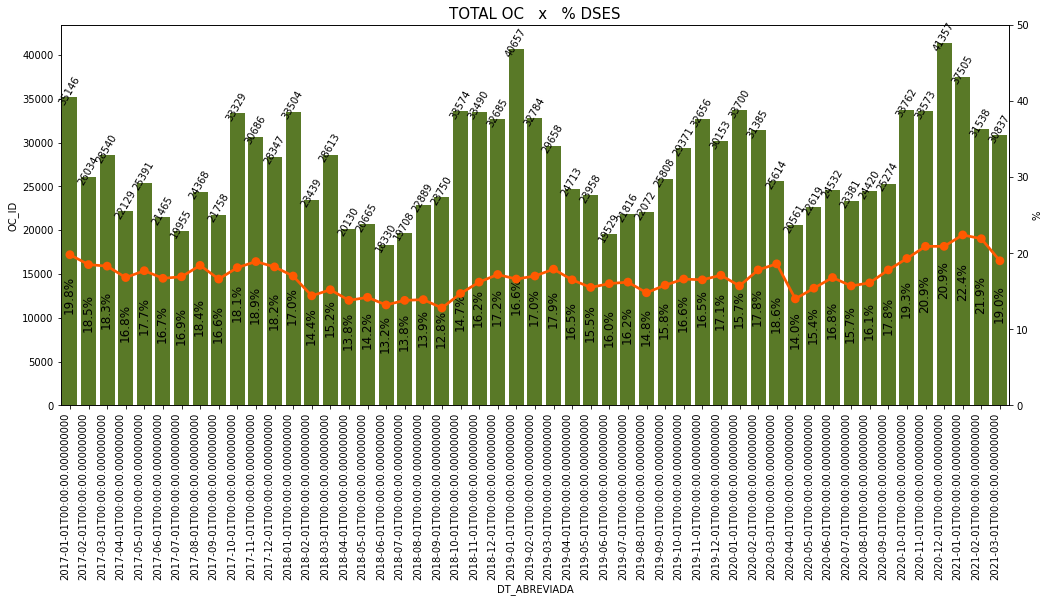

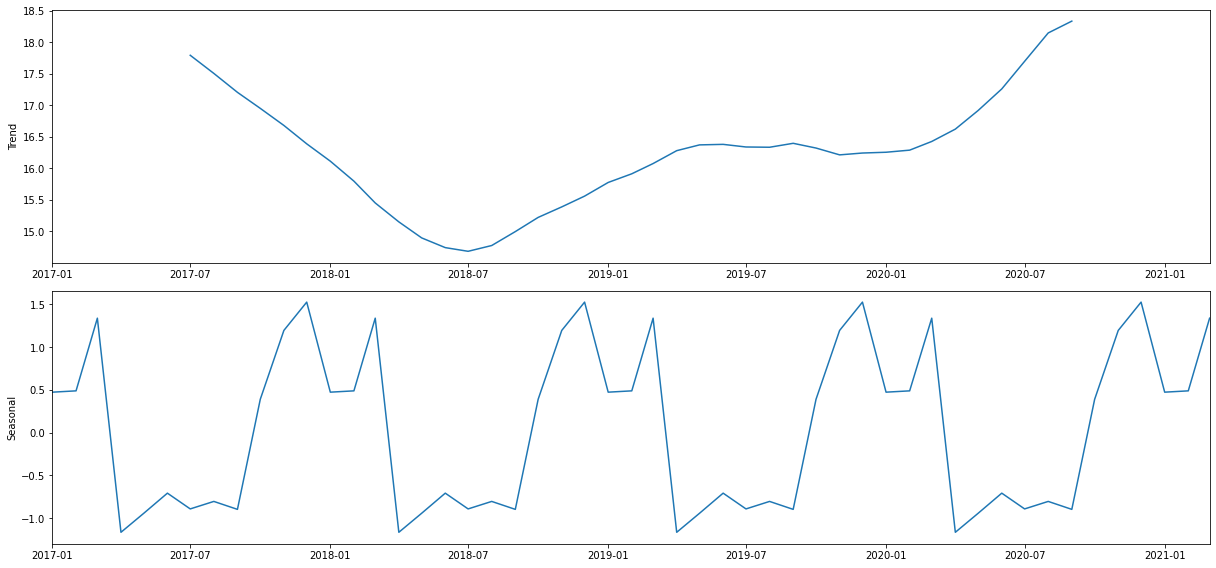

In [159]:
# TOTAL vs  % IMPRODUTIVOS

df = oc_elektro.sort_values('DT_ABREVIADA',ascending = True)
d = pd.DataFrame()
for i in df['DT_ABREVIADA'].unique():
    # total
    dd = df.loc[df['DT_ABREVIADA'] == i]
    dd = dd.groupby(['DT_ABREVIADA'],as_index = False)['OC_ID'].count()

    # improd
    dd1 = df.loc[(df['DT_ABREVIADA'] == i)&(df['DSES'] == 'S')]
    dd1 = dd1.groupby(['DT_ABREVIADA'],as_index = False)['OC_ID'].count()

    dd2 = pd.concat([dd,dd1['OC_ID']], axis = 1 ,ignore_index = True)

    d = pd.concat([d,dd2], axis = 0 ,ignore_index = True)
d = d.reset_index(drop = True)
d.columns = ['DT_ABREVIADA','OC_ID','IMPRODUTIVO']
d['%'] = round( 100 * d['IMPRODUTIVO']/d['OC_ID'],1)

df = d.copy()
#=======================================================================
#=======================================================================
#=======================================================================
fig, axes = plt.subplots(1,1,figsize=(17,7))

cplot = sns.barplot(x = 'DT_ABREVIADA', y = 'OC_ID', data = df,color = verde, ax = axes) 
for i,p in enumerate(cplot.patches):
    cplot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x(), p.get_height()), ha='center', va='center',rotation = 60, 
                    xytext=(7, 7), textcoords='offset points')
    cplot.annotate(str(df['%'].iat[i]) + '%', 
                   (p.get_x(), df['IMPRODUTIVO'].iat[i]), ha='center', va='center',rotation = 90, 
                    xytext=(7, 50), textcoords='offset points',fontsize=12)

ax2 = axes.twinx()
ax2.set_ylim([0,50])
lplot = sns.pointplot(x = 'DT_ABREVIADA', y = '%', data = df, ax=ax2, color=laranja)

axes.set_title('TOTAL OC   x   % DSES',fontsize = 15)
axes.set_xticklabels(axes.get_xticklabels(), rotation=90, horizontalalignment='right')
plt.xticks(rotation = 90)
plt.show()

def plot_temporal(df,valor):
    rcParams['figure.figsize'] = 17, 8
    y = df[['DT_ABREVIADA',valor]].copy()
    y.index = y['DT_ABREVIADA']
    y.drop('DT_ABREVIADA',axis = 1 , inplace = True)
    y = y[valor].resample('MS').mean()
    decomposition = sm.tsa.seasonal_decompose(y, model='additive')
    decomposition.plot(observed = False, resid = False)
    
#==============
plot_temporal(df,'%')

#### COLETIVA | INDIVIDUAL

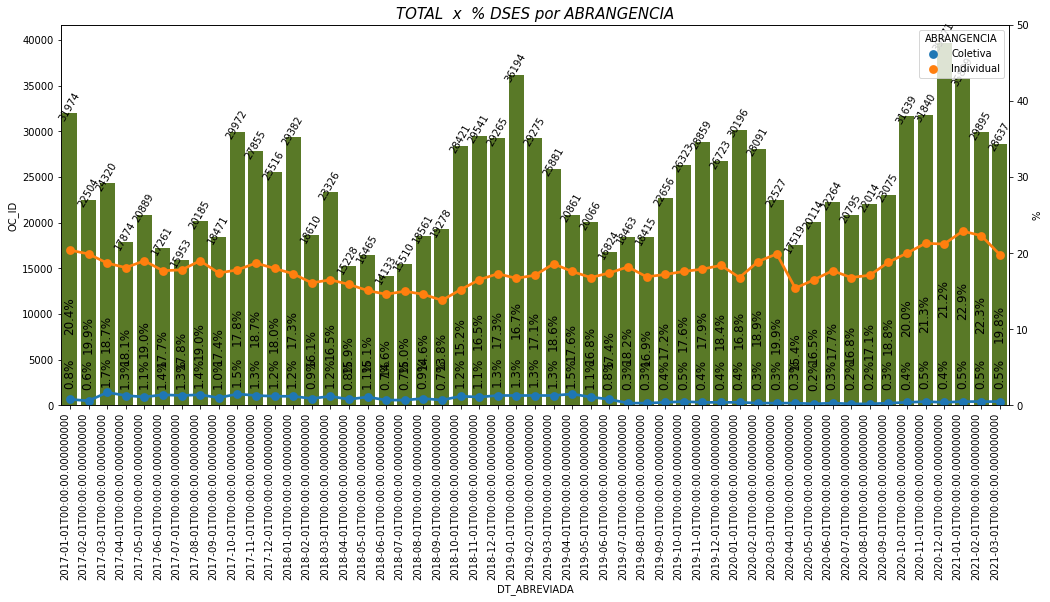

In [160]:
# POR COLETIVA | INDIVIDUAL

df = oc_elektro.sort_values('DT_ABREVIADA',ascending = True)
df = df.loc[df['ABRANGENCIA'] != 'Ilumicação Pública']

improd = pd.DataFrame()
total = pd.DataFrame() 
for i in df['DT_ABREVIADA'].unique():
    # total
    dd = df.loc[df['DT_ABREVIADA'] == i]
    dd = dd.groupby(['DT_ABREVIADA'],as_index = False)['OC_ID'].count()
    total = pd.concat([total,dd], axis = 0 ,ignore_index = True)
    
    # improd
    dd1 = df.loc[(df['DT_ABREVIADA'] == i)&(df['DSES'] == 'S')]
    dd1 = dd1.groupby(['DT_ABREVIADA','ABRANGENCIA'],as_index = False)['OC_ID'].count()
    dd1['%'] = round( 100 * dd1['OC_ID']/dd['OC_ID'].sum(),1)

    improd = pd.concat([improd,dd1], axis = 0 ,ignore_index = True)


#=======================================================================   
fig, axes = plt.subplots(1,1,figsize=(17,7))
plt.title('ELEKTRO - TOTAL  x  % ABRANGENCIA', style='italic',fontsize=15)

cplot = sns.barplot(x = 'DT_ABREVIADA', y = 'OC_ID', data = total,color = verde, ax = axes) 
for i,p in enumerate(cplot.patches):
    cplot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x(), p.get_height()), ha='center', va='center',rotation = 60, 
                    xytext=(7, 7), textcoords='offset points')
    for k in improd['ABRANGENCIA'].unique():
        df = improd.loc[improd['ABRANGENCIA'] == k]
        cplot.annotate(str(df['%'].iat[i]) + '%', 
                       (p.get_x(), df['OC_ID'].iat[i]), ha='center', va='center',rotation = 90, 
                        xytext=(7, 30), textcoords='offset points',fontsize=12)

ax2 = axes.twinx()
ax2.set_ylim([0,50])
lplot = sns.pointplot(x = 'DT_ABREVIADA', y = '%', data = improd,hue='ABRANGENCIA', 
                      ax=ax2,style = 'ABRANGENCIA')

axes.set_title('TOTAL  x  % DSES por ABRANGENCIA',fontsize = 15)
axes.set_xticklabels(axes.get_xticklabels(), rotation=90, horizontalalignment='right')
plt.xticks(rotation = 90)
plt.show()

#### GERAL DSES X 3 PRINCIPAIS CAUSAS

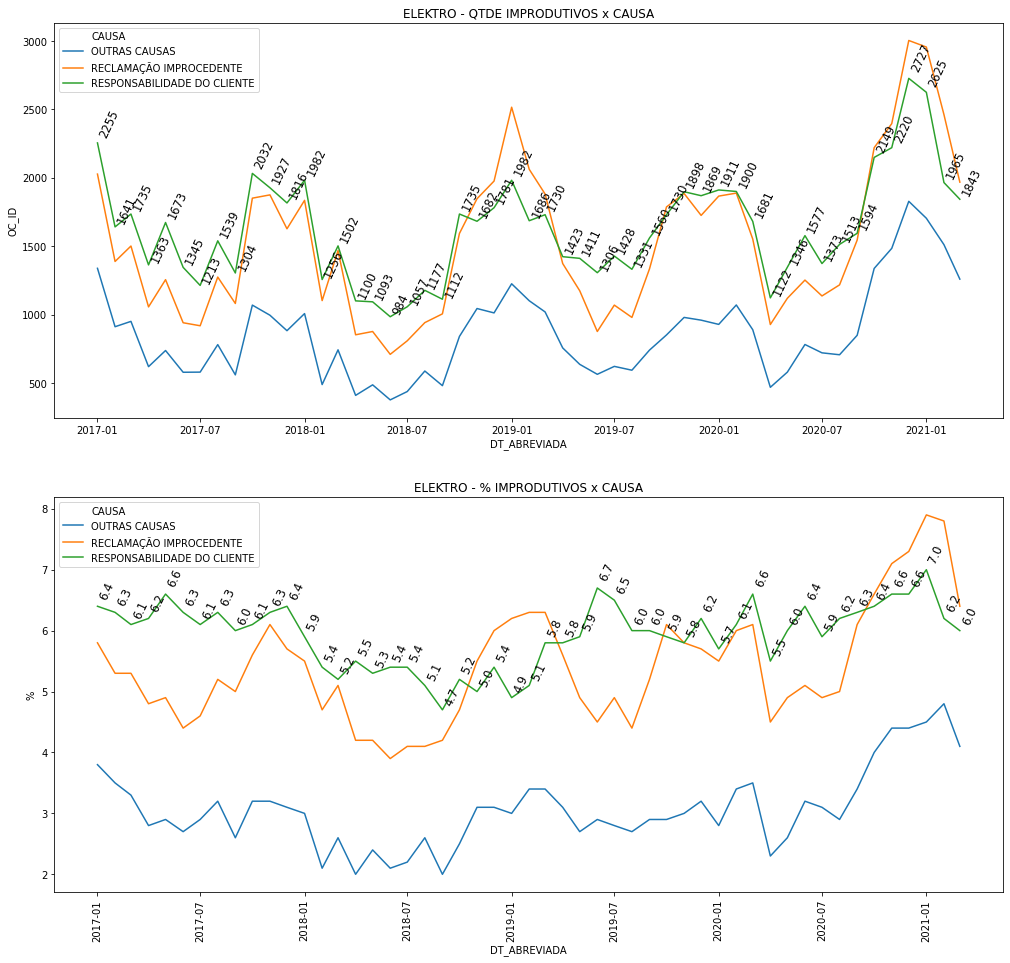

In [161]:
# PRINCIPAIS CAUSA DOS IMPRODUTIVOS

df = oc_elektro.sort_values('DT_ABREVIADA',ascending = True)

improd = pd.DataFrame()
total = pd.DataFrame() 
for i in df['DT_ABREVIADA'].unique():
    # total
    dd = df.loc[df['DT_ABREVIADA'] == i]
    dd = dd.groupby(['DT_ABREVIADA'],as_index = False)['OC_ID'].count()
    total = pd.concat([total,dd], axis = 0 ,ignore_index = True)
    
    # improd
    dd1 = df.loc[(df['DT_ABREVIADA'] == i)&(df['DSES'] == 'S')]
    dd1 = dd1.groupby(['DT_ABREVIADA','CAUSA'],as_index = False)['OC_ID'].count()
    dd1['%'] = round( 100 * dd1['OC_ID']/dd['OC_ID'].sum(),1)

    improd = pd.concat([improd,dd1], axis = 0 ,ignore_index = True)

improd = improd.loc[improd['CAUSA'].isin(['RESPONSABILIDADE DO CLIENTE',
                                             'RECLAMAÇÃO IMPROCEDENTE','OUTRAS CAUSAS'])]
#=======================================================================   
fig, axes = plt.subplots(2,1,figsize=(17,16))

sns.lineplot(x = 'DT_ABREVIADA', y = 'OC_ID', data = improd,hue = 'CAUSA',
             ax = axes[0],markers=True) 
axes[0].set_title('ELEKTRO - QTDE IMPRODUTIVOS x CAUSA')
for i in improd.index:
    if improd['CAUSA'][i] == 'RESPONSABILIDADE DO CLIENTE':
        axes[0].annotate(str(improd['OC_ID'][i]),
                     xy=(improd['DT_ABREVIADA'][i], improd['OC_ID'][i]),
                     xytext=(improd['DT_ABREVIADA'][i], improd['OC_ID'][i] + 0.02*improd['OC_ID'][i]),
                     fontsize = 11.5,rotation = 65)

sns.lineplot(x = 'DT_ABREVIADA', y = '%', data = improd,hue = 'CAUSA',
             ax = axes[1],markers=True)
axes[1].set_title('ELEKTRO - % IMPRODUTIVOS x CAUSA')
for i in improd.index:
    if improd['CAUSA'][i] == 'RESPONSABILIDADE DO CLIENTE':
        axes[1].annotate(str(improd['%'][i]),
                     xy=(improd['DT_ABREVIADA'][i], improd['%'][i]),
                     xytext=(improd['DT_ABREVIADA'][i], improd['%'][i] + 0.02*improd['%'][i]),
                     fontsize = 11.5,rotation = 65)


plt.xticks(rotation = 90)
plt.show()

#### GERAL POR PERIODO DE RECLAMAÇÃO

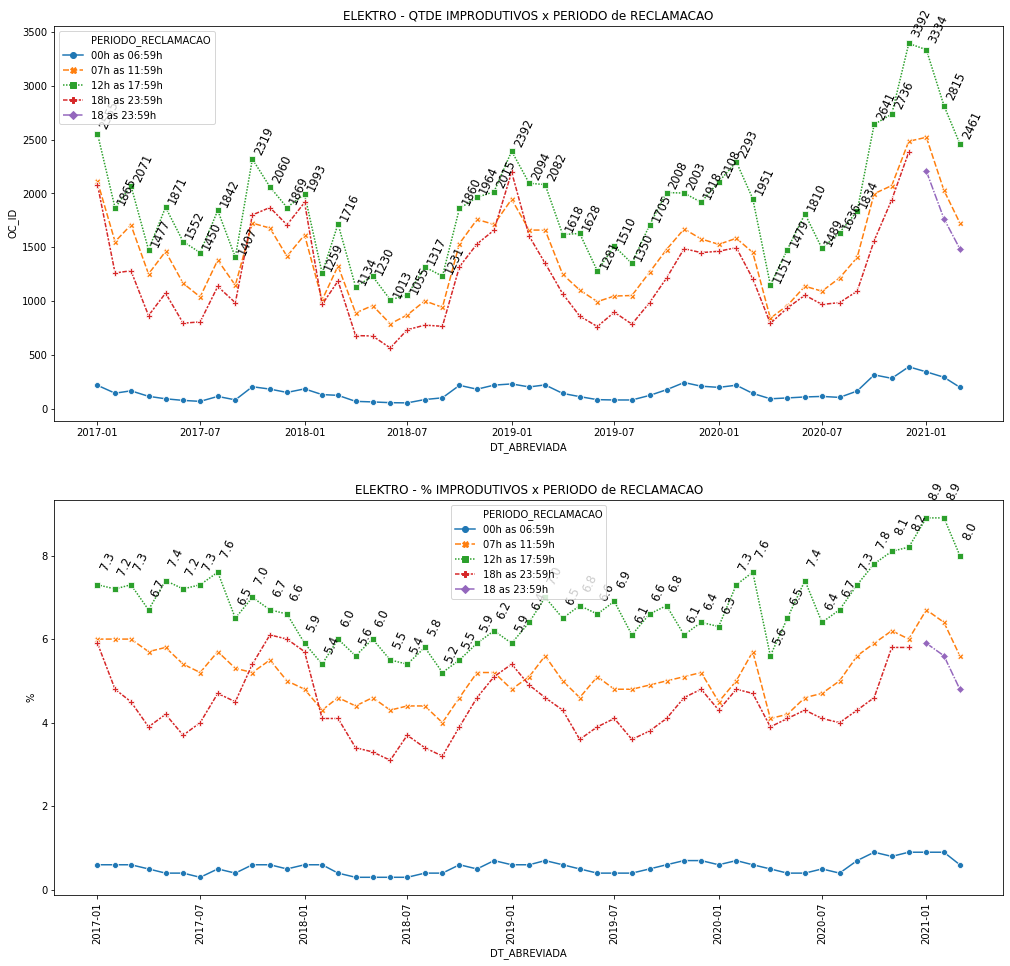

In [162]:
# POR PERIODO DE RECLAMAÇÃO

df = oc_elektro.sort_values('DT_ABREVIADA',ascending = True)

improd = pd.DataFrame()
total = pd.DataFrame() 
for i in df['DT_ABREVIADA'].unique():
    # total
    dd = df.loc[df['DT_ABREVIADA'] == i]
    dd = dd.groupby(['DT_ABREVIADA'],as_index = False)['OC_ID'].count()
    total = pd.concat([total,dd], axis = 0 ,ignore_index = True)
    
    # improd
    dd1 = df.loc[(df['DT_ABREVIADA'] == i)&(df['DSES'] == 'S')]
    dd1 = dd1.groupby(['DT_ABREVIADA','PERIODO_RECLAMACAO'],as_index = False)['OC_ID'].count()
    dd1['%'] = round( 100 * dd1['OC_ID']/dd['OC_ID'].sum(),1)

    improd = pd.concat([improd,dd1], axis = 0 ,ignore_index = True)


#=======================================================================   
fig, axes = plt.subplots(2,1,figsize=(17,16))

sns.lineplot(x = 'DT_ABREVIADA', y = 'OC_ID', data = improd,hue = 'PERIODO_RECLAMACAO',
             style = 'PERIODO_RECLAMACAO',ax = axes[0],markers=True) 
axes[0].set_title('ELEKTRO - QTDE IMPRODUTIVOS x PERIODO de RECLAMACAO')
for i in improd.index:
    if improd['PERIODO_RECLAMACAO'][i] == '12h as 17:59h':
        axes[0].annotate(str(improd['OC_ID'][i]),
                     xy=(improd['DT_ABREVIADA'][i], improd['OC_ID'][i]),
                     xytext=(improd['DT_ABREVIADA'][i], improd['OC_ID'][i] + 0.02*improd['OC_ID'][i]),
                     fontsize = 11.5,rotation = 65)

sns.lineplot(x = 'DT_ABREVIADA', y = '%', data = improd,hue = 'PERIODO_RECLAMACAO',
             style = 'PERIODO_RECLAMACAO',ax = axes[1],markers=True)
axes[1].set_title('ELEKTRO - % IMPRODUTIVOS x PERIODO de RECLAMACAO')
for i in improd.index:
    if improd['PERIODO_RECLAMACAO'][i] == '12h as 17:59h':
        axes[1].annotate(str(improd['%'][i]),
                     xy=(improd['DT_ABREVIADA'][i], improd['%'][i]),
                     xytext=(improd['DT_ABREVIADA'][i], improd['%'][i] + 0.05*improd['%'][i]),
                     fontsize = 11.5,rotation = 65)


plt.xticks(rotation = 90)
plt.show()

#### GERAL POR PERIODO DE CONCLUSAO

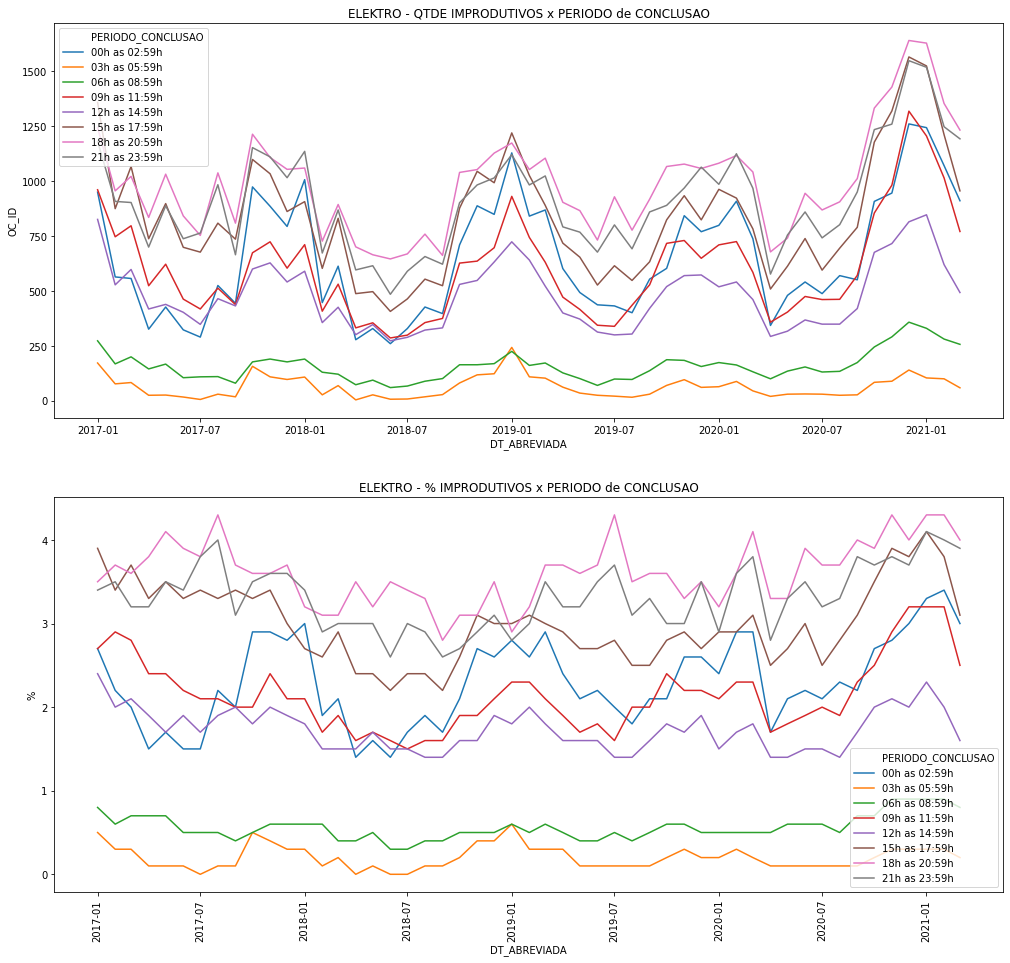

In [163]:
# POR PERIODO DE CONCLUSÃO

df = oc_elektro.sort_values('DT_ABREVIADA',ascending = True)

improd = pd.DataFrame()
total = pd.DataFrame() 
for i in df['DT_ABREVIADA'].unique():
    # total
    dd = df.loc[df['DT_ABREVIADA'] == i]
    dd = dd.groupby(['DT_ABREVIADA'],as_index = False)['OC_ID'].count()
    total = pd.concat([total,dd], axis = 0 ,ignore_index = True)
    
    # improd
    dd1 = df.loc[(df['DT_ABREVIADA'] == i)&(df['DSES'] == 'S')]
    dd1 = dd1.groupby(['DT_ABREVIADA','PERIODO_CONCLUSAO'],as_index = False)['OC_ID'].count()
    dd1['%'] = round( 100 * dd1['OC_ID']/dd['OC_ID'].sum(),1)

    improd = pd.concat([improd,dd1], axis = 0 ,ignore_index = True)


#=======================================================================   
fig, axes = plt.subplots(2,1,figsize=(17,16))

sns.lineplot(x = 'DT_ABREVIADA', y = 'OC_ID', data = improd,hue = 'PERIODO_CONCLUSAO',
             ax = axes[0],markers=True) 
axes[0].set_title('ELEKTRO - QTDE IMPRODUTIVOS x PERIODO de CONCLUSAO')
# for i in improd.index:
#     if improd['PERIODO_CONCLUSAO'][i] == '12h as 17:59h':
#         axes[0].annotate(str(improd['OC_ID'][i]),
#                      xy=(improd['DT_ABREVIADA'][i], improd['OC_ID'][i]),
#                      xytext=(improd['DT_ABREVIADA'][i], improd['OC_ID'][i] + 0.02*improd['OC_ID'][i]),
#                      fontsize = 11.5,rotation = 65)

sns.lineplot(x = 'DT_ABREVIADA', y = '%', data = improd,hue = 'PERIODO_CONCLUSAO',
             ax = axes[1],markers=True)
axes[1].set_title('ELEKTRO - % IMPRODUTIVOS x PERIODO de CONCLUSAO')
# for i in improd.index:
#     if improd['PERIODO_CONCLUSAO'][i] == '12h as 17:59h':
#         axes[1].annotate(str(improd['%'][i]),
#                      xy=(improd['DT_ABREVIADA'][i], improd['%'][i]),
#                      xytext=(improd['DT_ABREVIADA'][i], improd['%'][i] + 0.05*improd['%'][i]),
#                      fontsize = 11.5,rotation = 65)


plt.xticks(rotation = 90)
plt.show()

#### GERAL POR CLASSE DO CLIENTE

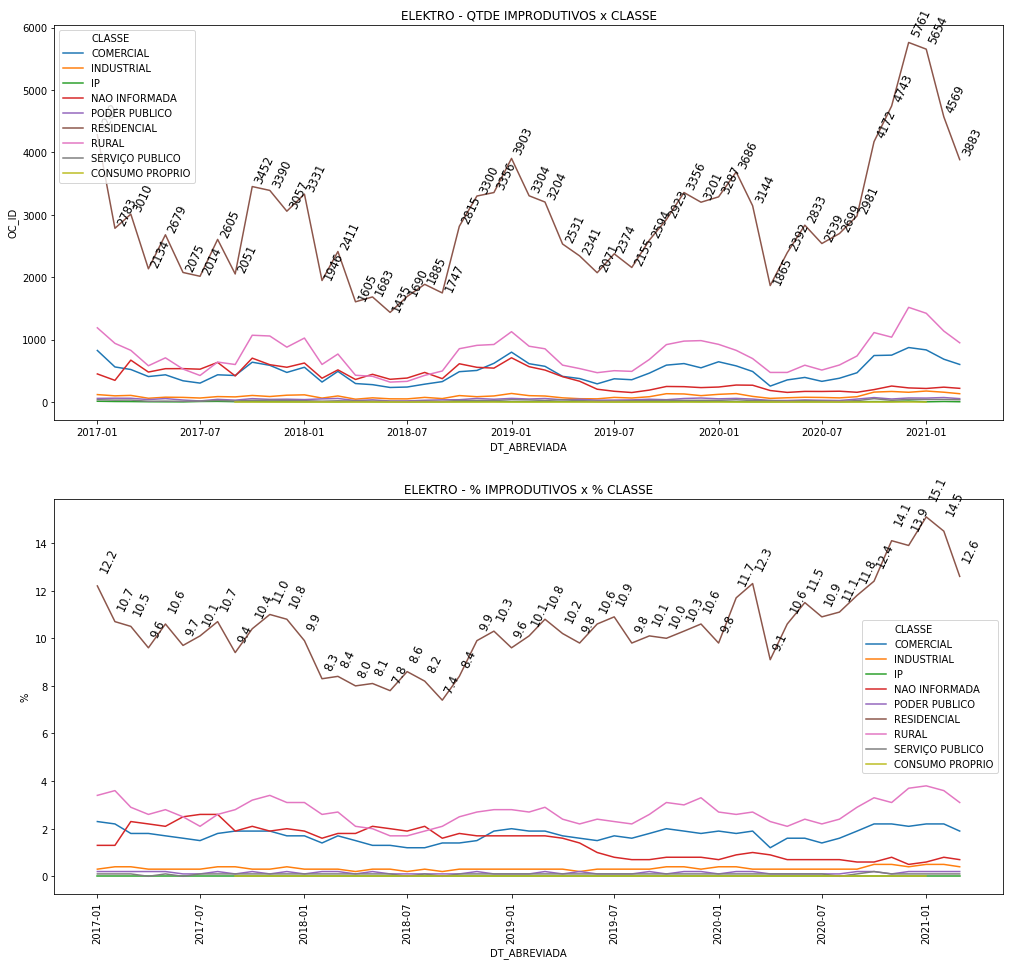

In [164]:
# POR CLASSE DO CLIENTE

df = oc_elektro.sort_values('DT_ABREVIADA',ascending = True)

improd = pd.DataFrame()
total = pd.DataFrame() 
for i in df['DT_ABREVIADA'].unique():
    # total
    dd = df.loc[df['DT_ABREVIADA'] == i]
    dd = dd.groupby(['DT_ABREVIADA'],as_index = False)['OC_ID'].count()
    total = pd.concat([total,dd], axis = 0 ,ignore_index = True)
    
    # improd
    dd1 = df.loc[(df['DT_ABREVIADA'] == i)&(df['DSES'] == 'S')]
    dd1 = dd1.groupby(['DT_ABREVIADA','CLASSE'],as_index = False)['OC_ID'].count()
    dd1['%'] = round( 100 * dd1['OC_ID']/dd['OC_ID'].sum(),1)

    improd = pd.concat([improd,dd1], axis = 0 ,ignore_index = True)


#=======================================================================   
fig, axes = plt.subplots(2,1,figsize=(17,16))

sns.lineplot(x = 'DT_ABREVIADA', y = 'OC_ID', data = improd,hue = 'CLASSE',
             ax = axes[0],markers=True) 
axes[0].set_title('ELEKTRO - QTDE IMPRODUTIVOS x CLASSE')
for i in improd.index:
    if improd['CLASSE'][i] == 'RESIDENCIAL':
        axes[0].annotate(str(improd['OC_ID'][i]),
                     xy=(improd['DT_ABREVIADA'][i], improd['OC_ID'][i]),
                     xytext=(improd['DT_ABREVIADA'][i], improd['OC_ID'][i] + 0.02*improd['OC_ID'][i]),
                     fontsize = 11.5,rotation = 65)

sns.lineplot(x = 'DT_ABREVIADA', y = '%', data = improd,hue = 'CLASSE',
             ax = axes[1],markers=True)
axes[1].set_title('ELEKTRO - % IMPRODUTIVOS x % CLASSE')
for i in improd.index:
    if improd['CLASSE'][i] == 'RESIDENCIAL':
        axes[1].annotate(str(improd['%'][i]),
                     xy=(improd['DT_ABREVIADA'][i], improd['%'][i]),
                     xytext=(improd['DT_ABREVIADA'][i], improd['%'][i] + 0.05*improd['%'][i]),
                     fontsize = 11.5,rotation = 65)


plt.xticks(rotation = 90)
plt.show()

#### GERAL DIA DA SEMANA X DSES

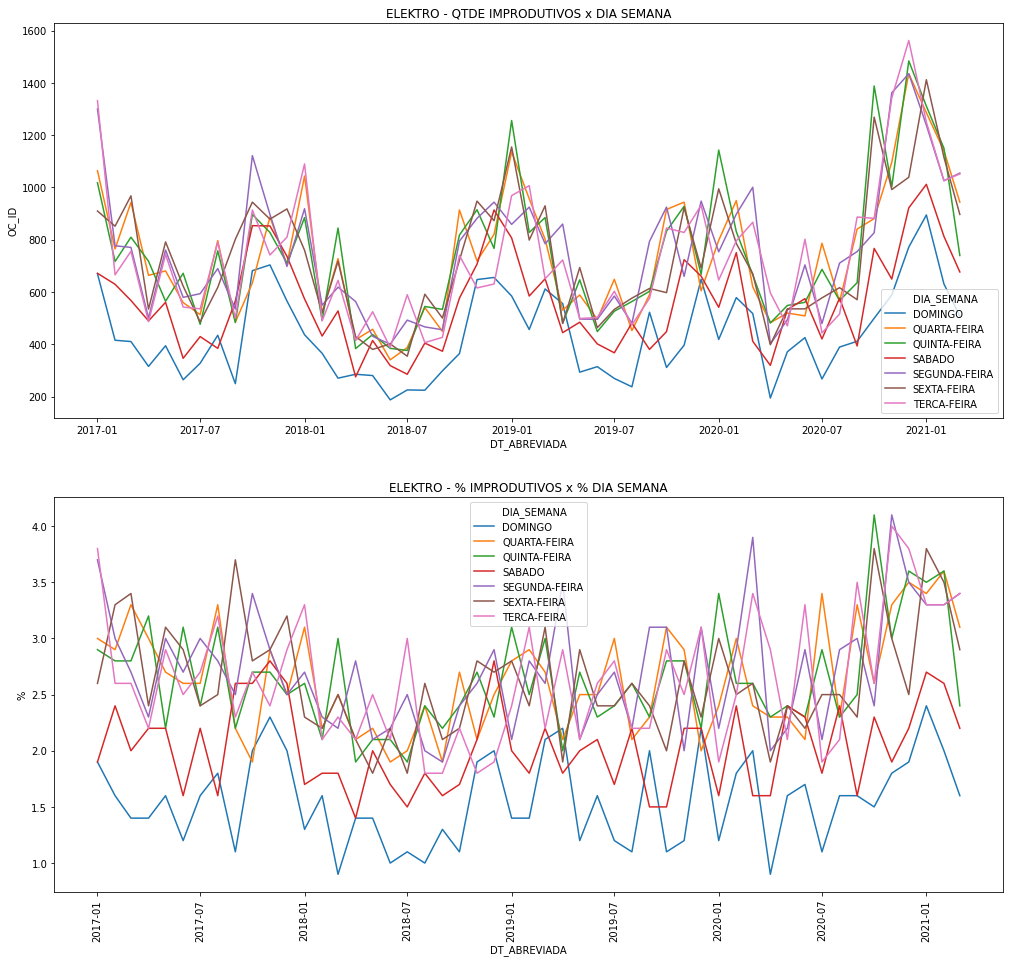

In [165]:
# POR DIA DA SEMANA

df = oc_elektro.sort_values('DT_ABREVIADA',ascending = True)

improd = pd.DataFrame()
total = pd.DataFrame() 
for i in df['DT_ABREVIADA'].unique():
    # total
    dd = df.loc[df['DT_ABREVIADA'] == i]
    dd = dd.groupby(['DT_ABREVIADA'],as_index = False)['OC_ID'].count()
    total = pd.concat([total,dd], axis = 0 ,ignore_index = True)
    
    # improd
    dd1 = df.loc[(df['DT_ABREVIADA'] == i)&(df['DSES'] == 'S')]
    dd1 = dd1.groupby(['DT_ABREVIADA','DIA_SEMANA'],as_index = False)['OC_ID'].count()
    dd1['%'] = round( 100 * dd1['OC_ID']/dd['OC_ID'].sum(),1)

    improd = pd.concat([improd,dd1], axis = 0 ,ignore_index = True)


#=======================================================================   
fig, axes = plt.subplots(2,1,figsize=(17,16))

sns.lineplot(x = 'DT_ABREVIADA', y = 'OC_ID', data = improd,hue = 'DIA_SEMANA',
             ax = axes[0],markers=True) 
axes[0].set_title('ELEKTRO - QTDE IMPRODUTIVOS x DIA SEMANA')
# for i in improd.index:
#     if improd['DIA_SEMANA'][i] == 'RESIDENCIAL':
#         axes[0].annotate(str(improd['OC_ID'][i]),
#                      xy=(improd['DT_ABREVIADA'][i], improd['OC_ID'][i]),
#                      xytext=(improd['DT_ABREVIADA'][i], improd['OC_ID'][i] + 0.02*improd['OC_ID'][i]),
#                      fontsize = 11.5,rotation = 65)

sns.lineplot(x = 'DT_ABREVIADA', y = '%', data = improd,hue = 'DIA_SEMANA',
             ax = axes[1],markers=True)
axes[1].set_title('ELEKTRO - % IMPRODUTIVOS x % DIA SEMANA')
# for i in improd.index:
#     if improd['DIA_SEMANA'][i] == 'RESIDENCIAL':
#         axes[1].annotate(str(improd['%'][i]),
#                      xy=(improd['DT_ABREVIADA'][i], improd['%'][i]),
#                      xytext=(improd['DT_ABREVIADA'][i], improd['%'][i] + 0.05*improd['%'][i]),
#                      fontsize = 11.5,rotation = 65)


plt.xticks(rotation = 90)
plt.show()

#### BARRAS - CAUSA X SETOR

In [166]:
oc_elektro['GERENCIA'].nunique()

12

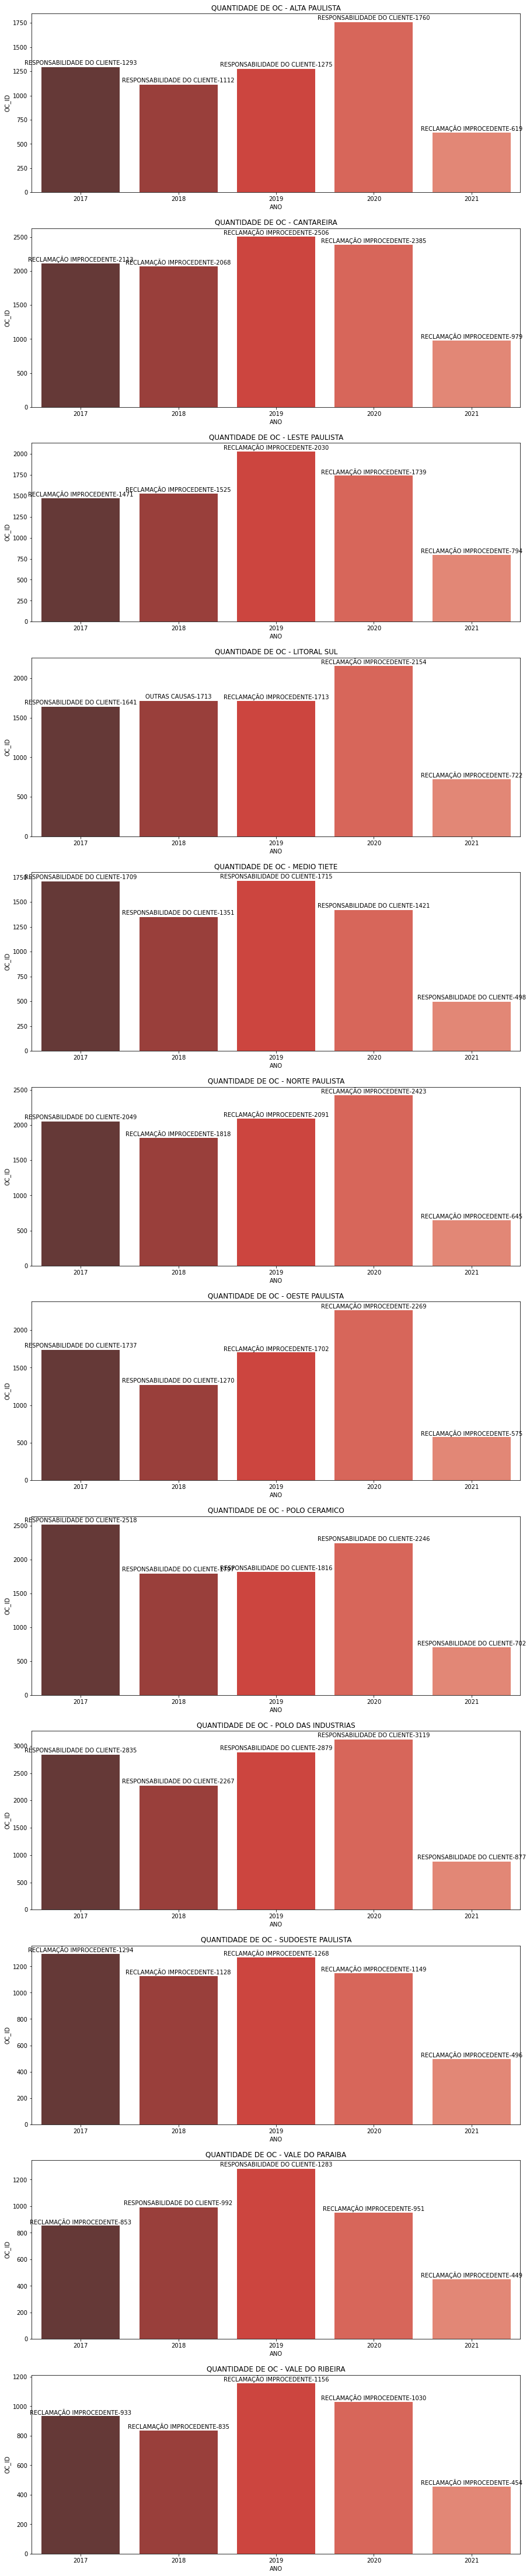

In [167]:
#### PLOT 'PRINCIPAL CAUSA POR SETOR AO LONGO DOS ANOS'

# PLOT PRINCIPAL CAUSA POR SETOR
elk_setor = oc_elektro.loc[oc_elektro['DSES'] == 'S']
elk_setor = elk_setor.groupby(['GERENCIA','ANO','CAUSA'],as_index=False)['OC_ID'].count()

fig, axes = plt.subplots(12,1,figsize=(15,80))

for i,j in enumerate(elk_setor['GERENCIA'].unique()):
    d = elk_setor.loc[elk_setor['GERENCIA'] == j]
    d.sort_values('OC_ID', ascending = False, inplace = True)
    d.drop_duplicates('ANO',inplace=True)
    d.sort_values('ANO', ascending = True, inplace = True)

    cplot = sns.barplot(x='ANO', y='OC_ID', data=d, ci=None, estimator=sum, palette=("Reds_d"),ax = axes[i])
    axes[i].set_title('QUANTIDADE DE OC - ' + j )
    for k,p in enumerate(cplot.patches):
        cplot.annotate(d['CAUSA'].iat[k] + '-' + format(p.get_height(), '.0f'), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', 
                        xytext=(0, 7), textcoords='offset points')
plt.show()

#### BARRAS - CAUSA X UTD

#### PARETO - CAUSAS | RECLAMAÇÕES X DSES

In [168]:
#### PARETO POR: 'PRINCIPAIS CAUSAS E RECLAMAÇÕES'

# PLOT POR CAUSA OU RECLAMAÇÃO, SSEGREGANDO ENTRE PRODUTIVO E ANO DA OC

# FUNCAO DO WIDGET
def plot_pareto_geral(df,status,ano):
    if status == 'N':
        status2 = 'PRODUTIVO'
        df = df.loc[df['DSES'] == 'N']
    else:
        status2 = 'IMPRODUTIVO'
        df = df.loc[df['DSES'] == 'S']
        

    df = df.loc[df['ANO'] == ano]
    df = df.groupby(['CAUSA','ANO'],as_index=False)['OC_ID'].count()
    df = df.sort_values('OC_ID',ascending = False)
    plot_pareto('ELEKTRO - CAUSAS apontadas em ' + str(ano) + ' - ' + status2,
                df.iloc[:25,:], 'CAUSA', 'OC_ID',var='soma')

#===========================================================================
#===========================================================================
#===========================================================================
# BOTOES
btn_status = widgets.Dropdown(
options = oc_elektro['DSES'].unique(),
value = oc_elektro['DSES'].iat[0],
description = 'houve dses?:',
disable = False)

btn_ano = widgets.Dropdown(
options = oc_elektro['ANO'].unique(),
value = oc_elektro['ANO'].iat[0],
description = 'ANO:',
disable = False)
      
        
        
# WIDGET CREATED      
widgets.interactive(plot_pareto_geral,df = fixed(oc_elektro),status=btn_status,ano = btn_ano)

interactive(children=(Dropdown(description='houve dses?:', options=('N', 'S'), value='N'), Dropdown(descriptio…

In [169]:
#### PARETO POR: 'PRINCIPAIS CAUSAS E RECLAMAÇÕES'

# PLOT POR CAUSA OU RECLAMAÇÃO, SSEGREGANDO ENTRE PRODUTIVO E ANO DA OC

# FUNCAO DO WIDGET
def plot_pareto_geral(df,status,ano):
    if status == 'N':
        status2 = 'PRODUTIVO'
        df = df.loc[df['DSES'] == 'N']
    else:
        status2 = 'IMPRODUTIVO'
        df = df.loc[df['DSES'] == 'S']
        

    df = df.loc[df['ANO'] == ano]
    df = df.groupby(['MOTIVO','ANO'],as_index=False)['OC_ID'].count()
    df = df.sort_values('OC_ID',ascending = False)
    plot_pareto('ELEKTRO - MOTIVOS apontados em ' + str(ano) + ' - ' + status2,
                df.iloc[:25,:], 'MOTIVO', 'OC_ID',var='soma')

#===========================================================================
#===========================================================================
#===========================================================================
# BOTOES
btn_status = widgets.Dropdown(
options = oc_elektro['DSES'].unique(),
value = oc_elektro['DSES'].iat[0],
description = 'houve dses?:',
disable = False)

btn_ano = widgets.Dropdown(
options = oc_elektro['ANO'].unique(),
value = oc_elektro['ANO'].iat[0],
description = 'ANO:',
disable = False)
      
        
        
# WIDGET CREATED      
widgets.interactive(plot_pareto_geral,df = fixed(oc_elektro),status=btn_status,ano = btn_ano)

interactive(children=(Dropdown(description='houve dses?:', options=('N', 'S'), value='N'), Dropdown(descriptio…

In [170]:
#### PARETO POR: 'PRINCIPAIS CAUSAS E RECLAMAÇÕES'

# PLOT POR CAUSA OU RECLAMAÇÃO, SSEGREGANDO ENTRE PRODUTIVO E ANO DA OC

# FUNCAO DO WIDGET
def plot_pareto_geral(df,status,ano):
    if status == 'N':
        status2 = 'PRODUTIVO'
        df = df.loc[df['DSES'] == 'N']
    else:
        status2 = 'IMPRODUTIVO'
        df = df.loc[df['DSES'] == 'S']
        

    df = df.loc[df['ANO'] == ano]
    df = df.groupby(['SUBMOTIVO','ANO'],as_index=False)['OC_ID'].count()
    df = df.sort_values('OC_ID',ascending = False)
    plot_pareto('ELEKTRO - SUBMOTIVOS apontados em ' + str(ano) + ' - ' + status2,
                df.iloc[:25,:], 'SUBMOTIVO', 'OC_ID',var='soma')

#===========================================================================
#===========================================================================
#===========================================================================
# BOTOES
btn_status = widgets.Dropdown(
options = oc_elektro['DSES'].unique(),
value = oc_elektro['DSES'].iat[0],
description = 'houve dses?:',
disable = False)

btn_ano = widgets.Dropdown(
options = oc_elektro['ANO'].unique(),
value = oc_elektro['ANO'].iat[0],
description = 'ANO:',
disable = False)
      
        
        
# WIDGET CREATED      
widgets.interactive(plot_pareto_geral,df = fixed(oc_elektro),status=btn_status,ano = btn_ano)

interactive(children=(Dropdown(description='houve dses?:', options=('N', 'S'), value='N'), Dropdown(descriptio…

### PARTE 2

In [171]:
oc_elektro.head()

,OC_ID,UC,CLASSE,NOX,NOY,LOCALIDADE,COD_LOCALIDADE,UTD,CAUSA,DSES,TIPO,DT_RECLAMACAO,DT_ACEITE,DT_CHEGADA,DT_CONCLUSAO,ABRANGENCIA,BOP,EQUIPE,ANO,DT_ABREVIADA,DIA_SEMANA,PERIODO_RECLAMACAO,PERIODO_CONCLUSAO,UTD_2,GERENCIA,LOCALIZACAO,NOX_2,NOY_2,LATITUDE,LONGITUDE,MOTIVO,SUBMOTIVO,CANAL_ATENDIMENTO,CANAL_ATENDIMENTO1
0,2016-752822,NaN,NAO INFORMADA,608934.55,7743402.34,VOTUPORANGA,746,VOTUPORANGA,RETORNO DE CONFIGURAÇÃO,N,Programado,2017-01-28 07:41:00,2017-01-28 09:12:00,2017-02-06 09:01:00,2017-02-06 09:01:00,Coletiva,VOTUPORANGA,COD-91,2017,2017-01-01,SABADO,07h as 11:59h,09h as 11:59h,VOTUPORANGA,NORTE PAULISTA,RURAL,608934.55,7743402.34,-20.40,-49.96,NaN,NaN,NaN,NaN
1,2016-938836,NaN,NAO INFORMADA,0.00,0.00,JARINU,121,ATIBAIA,MANUT. PREVENTIVA,N,Programado,2017-01-22 07:00:00,2017-01-22 07:49:00,2017-01-22 07:49:00,2017-01-22 13:56:00,Coletiva,JARINU,COD-90,2017,2017-01-01,DOMINGO,07h as 11:59h,12h as 14:59h,ATIBAIA,LESTE PAULISTA,URBANO,0.00,0.00,-250596920717.13,10259069066405.91,NaN,NaN,NaN,NaN
2,2016-1017280,NaN,NAO INFORMADA,508709.35,7765985.98,SANTA FE DO SUL,795,SANTA FE DO SUL,AVARIADA,N,Incidência,2017-01-05 17:00:00,2017-01-05 17:12:00,2017-01-05 17:15:00,2017-01-05 19:31:00,Ilumicação Pública,SANTA FE DO SUL,SFS-11,2017,2017-01-01,QUINTA-FEIRA,12h as 17:59h,18h as 20:59h,SANTA FE DO SUL,NORTE PAULISTA,URBANO,508709.35,7765985.98,-20.20,-50.92,NaN,NaN,NaN,NaN
3,2016-1086222,NaN,NAO INFORMADA,873202.63,7522905.00,ARARAS,69,ARARAS,RETORNO DE CONFIGURAÇÃO,N,Programado,2017-01-13 10:41:00,2017-01-13 10:44:00,2017-01-13 10:50:00,2017-01-13 11:09:00,Coletiva,ARARAS,ARR-13,2017,2017-01-01,SEXTA-FEIRA,07h as 11:59h,09h as 11:59h,ARARAS,POLO CERAMICO,URBANO,873202.63,7522905.00,-22.36,-47.38,NaN,NaN,NaN,NaN
4,2016-1114889,NaN,NAO INFORMADA,902762.20,7421554.31,CABREUVA,128,FRANCO DA ROCHA,RETORNO DE CONFIGURAÇÃO,N,Programado,2017-01-13 11:04:00,2017-01-13 11:06:00,2017-01-13 11:06:00,2017-01-13 14:39:00,Coletiva,CABREUVA,FRR-16,2017,2017-01-01,SEXTA-FEIRA,07h as 11:59h,12h as 14:59h,FRANCO DA ROCHA,CANTAREIRA,URBANO,902762.20,7421554.31,-23.27,-47.06,NaN,NaN,NaN,NaN


#### RECL e CAUSA por HR RECLAMACAO

In [172]:
causas = oc_elektro['CAUSA'].loc[(oc_elektro['DSES'] =='S')].value_counts().index[:4]
recl = oc_elektro['MOTIVO'].loc[(oc_elektro['DSES'] =='S')].value_counts().index[:4]
recl1 = oc_elektro['SUBMOTIVO'].loc[(oc_elektro['DSES'] =='S')].value_counts().index[:4]

In [173]:
# DSES - HORARIO RECLAMAÇÃO POR RECLAMACAO apontada

def exemplo(df1,causa):
    df = df1.sort_values('DT_ABREVIADA',ascending = True)
    df = df.loc[df['MOTIVO'] == causa]
    

    improd = pd.DataFrame()
    total = pd.DataFrame() 
    for i in df['DT_ABREVIADA'].unique():
        # total
        dd = df.loc[df['DT_ABREVIADA'] == i]
        dd = dd.groupby(['DT_ABREVIADA'],as_index = False)['OC_ID'].count()
        total = pd.concat([total,dd], axis = 0 ,ignore_index = True)

        # improd
        dd1 = df.loc[(df['DT_ABREVIADA'] == i)&(df['DSES'] == 'S')]
        dd1 = dd1.groupby(['DT_ABREVIADA','PERIODO_RECLAMACAO'],as_index = False)['OC_ID'].count()
        dd1['%'] = round( 100 * dd1['OC_ID']/dd['OC_ID'].sum(),1)

        improd = pd.concat([improd,dd1], axis = 0 ,ignore_index = True)


    #=======================================================================   
    fig, axes = plt.subplots(2,1,figsize=(17,16))

    sns.lineplot(x = 'DT_ABREVIADA', y = 'OC_ID', data = improd,hue = 'PERIODO_RECLAMACAO',
                 ax = axes[0],markers=True) 
    axes[0].set_title('ELEKTRO - QTDE IMPRODUTIVOS x HR RECLAMACAO')
    # for i in improd.index:
    #     if improd['CAUSA'][i] == 'FORNECIMENTO ENCONTRADO NORMAL':
    #         axes[0].annotate(str(improd['OC_ID'][i]),
    #                      xy=(improd['DT_ABREVIADA'][i], improd['OC_ID'][i]),
    #                      xytext=(improd['DT_ABREVIADA'][i], improd['OC_ID'][i] + 0.02*improd['OC_ID'][i]),
    #                      fontsize = 11.5,rotation = 65)

    sns.lineplot(x = 'DT_ABREVIADA', y = '%', data = improd,hue = 'PERIODO_RECLAMACAO',
                 ax = axes[1],markers=True)
    axes[1].set_title('ELEKTRO - % IMPRODUTIVOS x HR RECLAMACAO')
    # for i in improd.index:
    #     if improd['CAUSA'][i] == 'FORNECIMENTO ENCONTRADO NORMAL':
    #         axes[1].annotate(str(improd['%'][i]),
    #                      xy=(improd['DT_ABREVIADA'][i], improd['%'][i]),
    #                      xytext=(improd['DT_ABREVIADA'][i], improd['%'][i] + 0.02*improd['%'][i]),
    #                      fontsize = 11.5,rotation = 65)


    plt.xticks(rotation = 90)
    plt.show()
#===================================================================================
#===================================================================================
#===================================================================================

btn_recl = widgets.Dropdown(
options = recl,
value = recl[0],
description = 'RECL:',
disable = False)


# WIDGET CREATED 
widgets.interactive(exemplo ,df1 = fixed( oc_elektro ), causa = btn_recl )

interactive(children=(Dropdown(description='RECL:', options=('FALTA DE ENERGIA', 'PROVÁVEL DEFEITO FALHA', 'NI…

In [174]:
# DSES - HORARIO RECLAMAÇÃO POR CAUSA apontada

def exemplo(df1,causa):
    df = df1.sort_values('DT_ABREVIADA',ascending = True)
    df = df.loc[df['CAUSA'] == causa]
    

    improd = pd.DataFrame()
    total = pd.DataFrame() 
    for i in df['DT_ABREVIADA'].unique():
        # total
        dd = df.loc[df['DT_ABREVIADA'] == i]
        dd = dd.groupby(['DT_ABREVIADA'],as_index = False)['OC_ID'].count()
        total = pd.concat([total,dd], axis = 0 ,ignore_index = True)

        # improd
        dd1 = df.loc[(df['DT_ABREVIADA'] == i)&(df['DSES'] == 'S')]
        dd1 = dd1.groupby(['DT_ABREVIADA','PERIODO_RECLAMACAO'],as_index = False)['OC_ID'].count()
        dd1['%'] = round( 100 * dd1['OC_ID']/dd['OC_ID'].sum(),1)

        improd = pd.concat([improd,dd1], axis = 0 ,ignore_index = True)


    #=======================================================================   
    fig, axes = plt.subplots(2,1,figsize=(17,16))

    sns.lineplot(x = 'DT_ABREVIADA', y = 'OC_ID', data = improd,hue = 'PERIODO_RECLAMACAO',
                 ax = axes[0],markers=True) 
    axes[0].set_title('ELEKTRO - QTDE IMPRODUTIVOS x HR RECLAMACAO')
    # for i in improd.index:
    #     if improd['CAUSA'][i] == 'FORNECIMENTO ENCONTRADO NORMAL':
    #         axes[0].annotate(str(improd['OC_ID'][i]),
    #                      xy=(improd['DT_ABREVIADA'][i], improd['OC_ID'][i]),
    #                      xytext=(improd['DT_ABREVIADA'][i], improd['OC_ID'][i] + 0.02*improd['OC_ID'][i]),
    #                      fontsize = 11.5,rotation = 65)

    sns.lineplot(x = 'DT_ABREVIADA', y = '%', data = improd,hue = 'PERIODO_RECLAMACAO',
                 ax = axes[1],markers=True)
    axes[1].set_title('ELEKTRO - % IMPRODUTIVOS x HR RECLAMACAO')
    # for i in improd.index:
    #     if improd['CAUSA'][i] == 'FORNECIMENTO ENCONTRADO NORMAL':
    #         axes[1].annotate(str(improd['%'][i]),
    #                      xy=(improd['DT_ABREVIADA'][i], improd['%'][i]),
    #                      xytext=(improd['DT_ABREVIADA'][i], improd['%'][i] + 0.02*improd['%'][i]),
    #                      fontsize = 11.5,rotation = 65)


    plt.xticks(rotation = 90)
    plt.show()
#===================================================================================
#===================================================================================
#===================================================================================

btn_causa = widgets.Dropdown(
options = causas,
value = causas[0],
description = 'CAUSA:',
disable = False)


# WIDGET CREATED 
widgets.interactive(exemplo ,df1 = fixed( oc_elektro ), causa = btn_causa )

interactive(children=(Dropdown(description='CAUSA:', options=('RESPONSABILIDADE DO CLIENTE', 'RECLAMAÇÃO IMPRO…

#### RECL e CAUSA por HR CONCLUSAO

In [175]:
# DSES - HORARIO CONCLUSAO POR RECLAMACAO apontada

def exemplo(df1,causa):
    df = df1.sort_values('DT_ABREVIADA',ascending = True)
    df = df.loc[df['MOTIVO'] == causa]
    

    improd = pd.DataFrame()
    total = pd.DataFrame() 
    for i in df['DT_ABREVIADA'].unique():
        # total
        dd = df.loc[df['DT_ABREVIADA'] == i]
        dd = dd.groupby(['DT_ABREVIADA'],as_index = False)['OC_ID'].count()
        total = pd.concat([total,dd], axis = 0 ,ignore_index = True)

        # improd
        dd1 = df.loc[(df['DT_ABREVIADA'] == i)&(df['DSES'] == 'S')]
        dd1 = dd1.groupby(['DT_ABREVIADA','PERIODO_CONCLUSAO'],as_index = False)['OC_ID'].count()
        dd1['%'] = round( 100 * dd1['OC_ID']/dd['OC_ID'].sum(),1)

        improd = pd.concat([improd,dd1], axis = 0 ,ignore_index = True)


    #=======================================================================   
    fig, axes = plt.subplots(2,1,figsize=(17,16))

    sns.lineplot(x = 'DT_ABREVIADA', y = 'OC_ID', data = improd,hue = 'PERIODO_CONCLUSAO',
                 ax = axes[0],markers=True) 
    axes[0].set_title('ELEKTRO - QTDE IMPRODUTIVOS x HR CONCLUSAO')
    # for i in improd.index:
    #     if improd['CAUSA'][i] == 'FORNECIMENTO ENCONTRADO NORMAL':
    #         axes[0].annotate(str(improd['OC_ID'][i]),
    #                      xy=(improd['DT_ABREVIADA'][i], improd['OC_ID'][i]),
    #                      xytext=(improd['DT_ABREVIADA'][i], improd['OC_ID'][i] + 0.02*improd['OC_ID'][i]),
    #                      fontsize = 11.5,rotation = 65)

    sns.lineplot(x = 'DT_ABREVIADA', y = '%', data = improd,hue = 'PERIODO_CONCLUSAO',
                 ax = axes[1],markers=True)
    axes[1].set_title('ELEKTRO - % IMPRODUTIVOS x HR CONCLUSAO')
    # for i in improd.index:
    #     if improd['CAUSA'][i] == 'FORNECIMENTO ENCONTRADO NORMAL':
    #         axes[1].annotate(str(improd['%'][i]),
    #                      xy=(improd['DT_ABREVIADA'][i], improd['%'][i]),
    #                      xytext=(improd['DT_ABREVIADA'][i], improd['%'][i] + 0.02*improd['%'][i]),
    #                      fontsize = 11.5,rotation = 65)


    plt.xticks(rotation = 90)
    plt.show()
#===================================================================================
#===================================================================================
#===================================================================================

btn_recl = widgets.Dropdown(
options = recl,
value = recl[0],
description = 'RECL:',
disable = False)


# WIDGET CREATED 
widgets.interactive(exemplo ,df1 = fixed( oc_elektro ), causa = btn_recl )

interactive(children=(Dropdown(description='RECL:', options=('FALTA DE ENERGIA', 'PROVÁVEL DEFEITO FALHA', 'NI…

In [176]:
# DSES - HORARIO CONCLUSAO POR CAUSA apontada

def exemplo(df1,causa):
    df = df1.sort_values('DT_ABREVIADA',ascending = True)
    df = df.loc[df['CAUSA'] == causa]
    

    improd = pd.DataFrame()
    total = pd.DataFrame() 
    for i in df['DT_ABREVIADA'].unique():
        # total
        dd = df.loc[df['DT_ABREVIADA'] == i]
        dd = dd.groupby(['DT_ABREVIADA'],as_index = False)['OC_ID'].count()
        total = pd.concat([total,dd], axis = 0 ,ignore_index = True)

        # improd
        dd1 = df.loc[(df['DT_ABREVIADA'] == i)&(df['DSES'] == 'S')]
        dd1 = dd1.groupby(['DT_ABREVIADA','PERIODO_CONCLUSAO'],as_index = False)['OC_ID'].count()
        dd1['%'] = round( 100 * dd1['OC_ID']/dd['OC_ID'].sum(),1)

        improd = pd.concat([improd,dd1], axis = 0 ,ignore_index = True)


    #=======================================================================   
    fig, axes = plt.subplots(2,1,figsize=(17,16))

    sns.lineplot(x = 'DT_ABREVIADA', y = 'OC_ID', data = improd,hue = 'PERIODO_CONCLUSAO',
                 ax = axes[0],markers=True) 
    axes[0].set_title('ELEKTRO - QTDE IMPRODUTIVOS x HR CONCLUSAO')
    # for i in improd.index:
    #     if improd['CAUSA'][i] == 'FORNECIMENTO ENCONTRADO NORMAL':
    #         axes[0].annotate(str(improd['OC_ID'][i]),
    #                      xy=(improd['DT_ABREVIADA'][i], improd['OC_ID'][i]),
    #                      xytext=(improd['DT_ABREVIADA'][i], improd['OC_ID'][i] + 0.02*improd['OC_ID'][i]),
    #                      fontsize = 11.5,rotation = 65)

    sns.lineplot(x = 'DT_ABREVIADA', y = '%', data = improd,hue = 'PERIODO_CONCLUSAO',
                 ax = axes[1],markers=True)
    axes[1].set_title('ELEKTRO - % IMPRODUTIVOS x HR CONCLUSAO')
    # for i in improd.index:
    #     if improd['CAUSA'][i] == 'FORNECIMENTO ENCONTRADO NORMAL':
    #         axes[1].annotate(str(improd['%'][i]),
    #                      xy=(improd['DT_ABREVIADA'][i], improd['%'][i]),
    #                      xytext=(improd['DT_ABREVIADA'][i], improd['%'][i] + 0.02*improd['%'][i]),
    #                      fontsize = 11.5,rotation = 65)


    plt.xticks(rotation = 90)
    plt.show()
#===================================================================================
#===================================================================================
#===================================================================================

btn_causa = widgets.Dropdown(
options = causas,
value = causas[0],
description = 'CAUSA:',
disable = False)


# WIDGET CREATED 
widgets.interactive(exemplo ,df1 = fixed( oc_elektro ), causa = btn_causa )

interactive(children=(Dropdown(description='CAUSA:', options=('RESPONSABILIDADE DO CLIENTE', 'RECLAMAÇÃO IMPRO…

#### PARETO

In [177]:
causas = oc_elektro['CAUSA'].loc[(oc_elektro['DSES'] =='S')&
                               (oc_elektro['ANO'] ==2020)].value_counts().index[:5]

def plot_pareto_wid(df,causa):
    pareto_celpe = df.loc[df['CAUSA']==causa]
    pareto_celpe = pareto_celpe.loc[(pareto_celpe['DSES'] =='S')&
                                   (pareto_celpe['ANO'] ==2020)]

    pareto_celpe = sumarizar_coluna_geral(pareto_celpe,'CAUSA','PERIODO_CONCLUSAO','OC_ID','nao')
    plot_pareto(causa, pareto_celpe, 'PERIODO_CONCLUSAO', 'OC_ID',var='soma')

#==========================================================
btn_pareto = widgets.Dropdown(
options = causas,
value = causas[0],
description = 'CAUSA:',
disable = False)

# WIDGET CREATED 
widgets.interactive(plot_pareto_wid ,df = fixed( oc_elektro ), causa = btn_pareto )

interactive(children=(Dropdown(description='CAUSA:', options=('RESPONSABILIDADE DO CLIENTE', 'RECLAMAÇÃO IMPRO…

#### REL EQUIPE

In [178]:
# VERIFICAR COMO PEGAR EQUIPE E TIPO EQUIPE

# plantao: 10 A 19
# STC: 3 DIGITOS (INICIA COM 6)
# EQUIPES QUE INICIAM COM 2: DIGGER, GUINDAUTO, (CAMINHOES PESADOS)... pode ter equipe de poda (preventiva)
# equipes que iniciam com 3: equipes de obras (cesta aerea) (linha morta)
# equipes que iniciam com 4: cesta aerea linha viva
# confirmar se as equipes de obras permanecem com 2 letras no prefixo

In [179]:
oc_elektro.head()

,OC_ID,UC,CLASSE,NOX,NOY,LOCALIDADE,COD_LOCALIDADE,UTD,CAUSA,DSES,TIPO,DT_RECLAMACAO,DT_ACEITE,DT_CHEGADA,DT_CONCLUSAO,ABRANGENCIA,BOP,EQUIPE,ANO,DT_ABREVIADA,DIA_SEMANA,PERIODO_RECLAMACAO,PERIODO_CONCLUSAO,UTD_2,GERENCIA,LOCALIZACAO,NOX_2,NOY_2,LATITUDE,LONGITUDE,MOTIVO,SUBMOTIVO,CANAL_ATENDIMENTO,CANAL_ATENDIMENTO1
0,2016-752822,NaN,NAO INFORMADA,608934.55,7743402.34,VOTUPORANGA,746,VOTUPORANGA,RETORNO DE CONFIGURAÇÃO,N,Programado,2017-01-28 07:41:00,2017-01-28 09:12:00,2017-02-06 09:01:00,2017-02-06 09:01:00,Coletiva,VOTUPORANGA,COD-91,2017,2017-01-01,SABADO,07h as 11:59h,09h as 11:59h,VOTUPORANGA,NORTE PAULISTA,RURAL,608934.55,7743402.34,-20.40,-49.96,NaN,NaN,NaN,NaN
1,2016-938836,NaN,NAO INFORMADA,0.00,0.00,JARINU,121,ATIBAIA,MANUT. PREVENTIVA,N,Programado,2017-01-22 07:00:00,2017-01-22 07:49:00,2017-01-22 07:49:00,2017-01-22 13:56:00,Coletiva,JARINU,COD-90,2017,2017-01-01,DOMINGO,07h as 11:59h,12h as 14:59h,ATIBAIA,LESTE PAULISTA,URBANO,0.00,0.00,-250596920717.13,10259069066405.91,NaN,NaN,NaN,NaN
2,2016-1017280,NaN,NAO INFORMADA,508709.35,7765985.98,SANTA FE DO SUL,795,SANTA FE DO SUL,AVARIADA,N,Incidência,2017-01-05 17:00:00,2017-01-05 17:12:00,2017-01-05 17:15:00,2017-01-05 19:31:00,Ilumicação Pública,SANTA FE DO SUL,SFS-11,2017,2017-01-01,QUINTA-FEIRA,12h as 17:59h,18h as 20:59h,SANTA FE DO SUL,NORTE PAULISTA,URBANO,508709.35,7765985.98,-20.20,-50.92,NaN,NaN,NaN,NaN
3,2016-1086222,NaN,NAO INFORMADA,873202.63,7522905.00,ARARAS,69,ARARAS,RETORNO DE CONFIGURAÇÃO,N,Programado,2017-01-13 10:41:00,2017-01-13 10:44:00,2017-01-13 10:50:00,2017-01-13 11:09:00,Coletiva,ARARAS,ARR-13,2017,2017-01-01,SEXTA-FEIRA,07h as 11:59h,09h as 11:59h,ARARAS,POLO CERAMICO,URBANO,873202.63,7522905.00,-22.36,-47.38,NaN,NaN,NaN,NaN
4,2016-1114889,NaN,NAO INFORMADA,902762.20,7421554.31,CABREUVA,128,FRANCO DA ROCHA,RETORNO DE CONFIGURAÇÃO,N,Programado,2017-01-13 11:04:00,2017-01-13 11:06:00,2017-01-13 11:06:00,2017-01-13 14:39:00,Coletiva,CABREUVA,FRR-16,2017,2017-01-01,SEXTA-FEIRA,07h as 11:59h,12h as 14:59h,FRANCO DA ROCHA,CANTAREIRA,URBANO,902762.20,7421554.31,-23.27,-47.06,NaN,NaN,NaN,NaN


In [180]:
eqp = pd.DataFrame(oc_elektro[['EQUIPE']])
eqp = eqp.drop_duplicates('EQUIPE')
eqp[['PREFIXO','CODIGO','CODIGO1']] = eqp['EQUIPE'].str.split('-', expand = True)
eqp = eqp[['EQUIPE','PREFIXO','CODIGO']]
eqp = eqp.loc[(~eqp['CODIGO'].isna()) & (eqp['CODIGO'].str.isnumeric())]
eqp['CODIGO'] = eqp['CODIGO'].astype(int)
eqp.loc[(eqp['CODIGO'] >= 10) & (eqp['CODIGO'] < 20),'TIPO_EQUIPE'] = 'PLANTAO'
eqp.loc[(eqp['CODIGO'] >= 600) & (eqp['CODIGO'] < 700),'TIPO_EQUIPE'] = 'STC'
eqp.loc[eqp['TIPO_EQUIPE'].isna(),'TIPO_EQUIPE'] = 'OUTROS'
eqp

,EQUIPE,PREFIXO,CODIGO,TIPO_EQUIPE
0,COD-91,COD,91,OUTROS
1,COD-90,COD,90,OUTROS
2,SFS-11,SFS,11,PLANTAO
3,ARR-13,ARR,13,PLANTAO
4,FRR-16,FRR,16,PLANTAO
...,...,...,...,...
1379358,BER-11,BER,11,PLANTAO
1381768,SRA-03,SRA,3,OUTROS
1387767,ATI-957,ATI,957,OUTROS
1389952,TIE-10,TIE,10,PLANTAO


In [181]:
print(oc_elektro.shape)
oc_elektro1 = oc_elektro.merge(eqp[['EQUIPE','TIPO_EQUIPE']], on = 'EQUIPE', how = 'left')
oc_elektro1.loc[oc_elektro1['TIPO_EQUIPE'].isna(),'TIPO_EQUIPE'] = 'OUTROS'
print(oc_elektro1.shape)

(1401158, 34)
(1401158, 35)


56.97


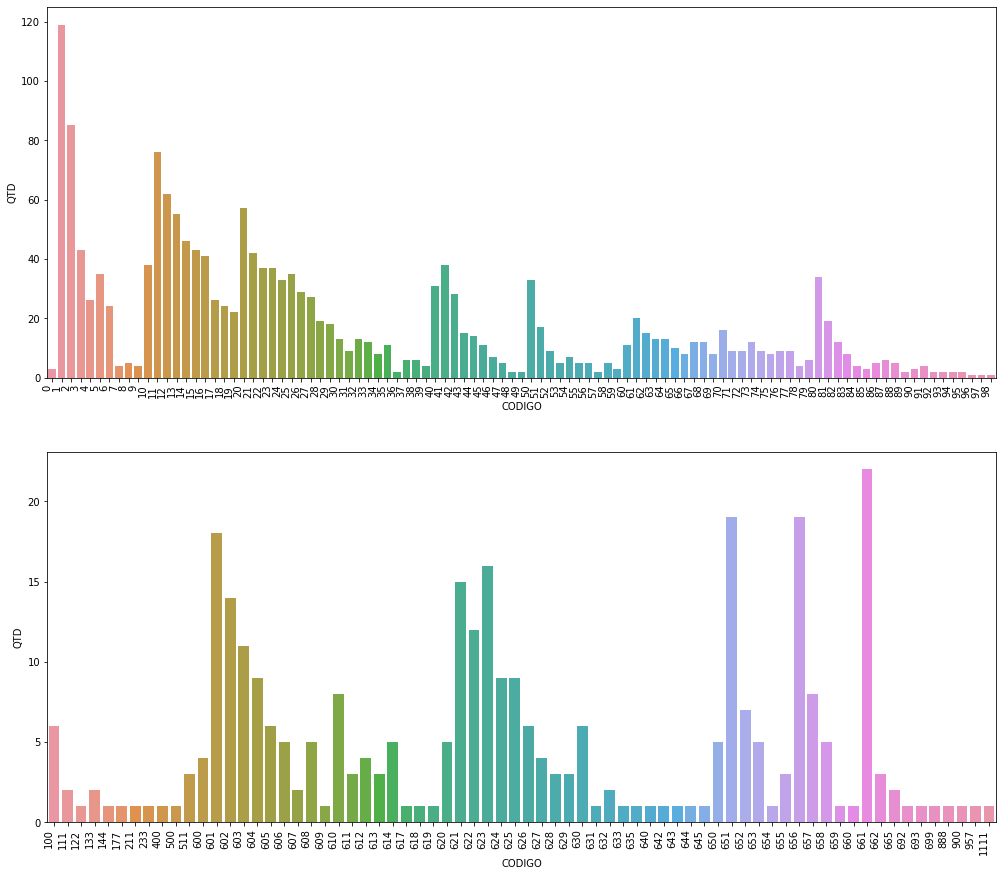

In [182]:
#PLOT QUANTIDADE DE OCs por EQUIPE - SEGREGADA

a = eqp.loc[eqp['CODIGO'] < 100]
a['QTD'] = a['CODIGO']
a = a.groupby('CODIGO',as_index = False)['QTD'].count()

b = eqp.loc[eqp['CODIGO'] >= 100]
b['QTD'] = b['CODIGO']
b = b.groupby('CODIGO',as_index = False)['QTD'].count()

c = a['QTD'].loc[(a['CODIGO'] >= 10) & (a['CODIGO'] < 20)].sum()
d = a['QTD'].loc[(a['CODIGO'] < 10) & (a['CODIGO'] >= 20)].sum() + b['QTD'].sum()
print(round(100*c/(c+d),2))

fig, axes = plt.subplots(2,1,figsize = (17,15))
sns.barplot(x = 'CODIGO',y= 'QTD',data= a, ax = axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90, horizontalalignment='right')
sns.barplot(x = 'CODIGO',y= 'QTD',data= b, ax = axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90, horizontalalignment='right')
plt.show()

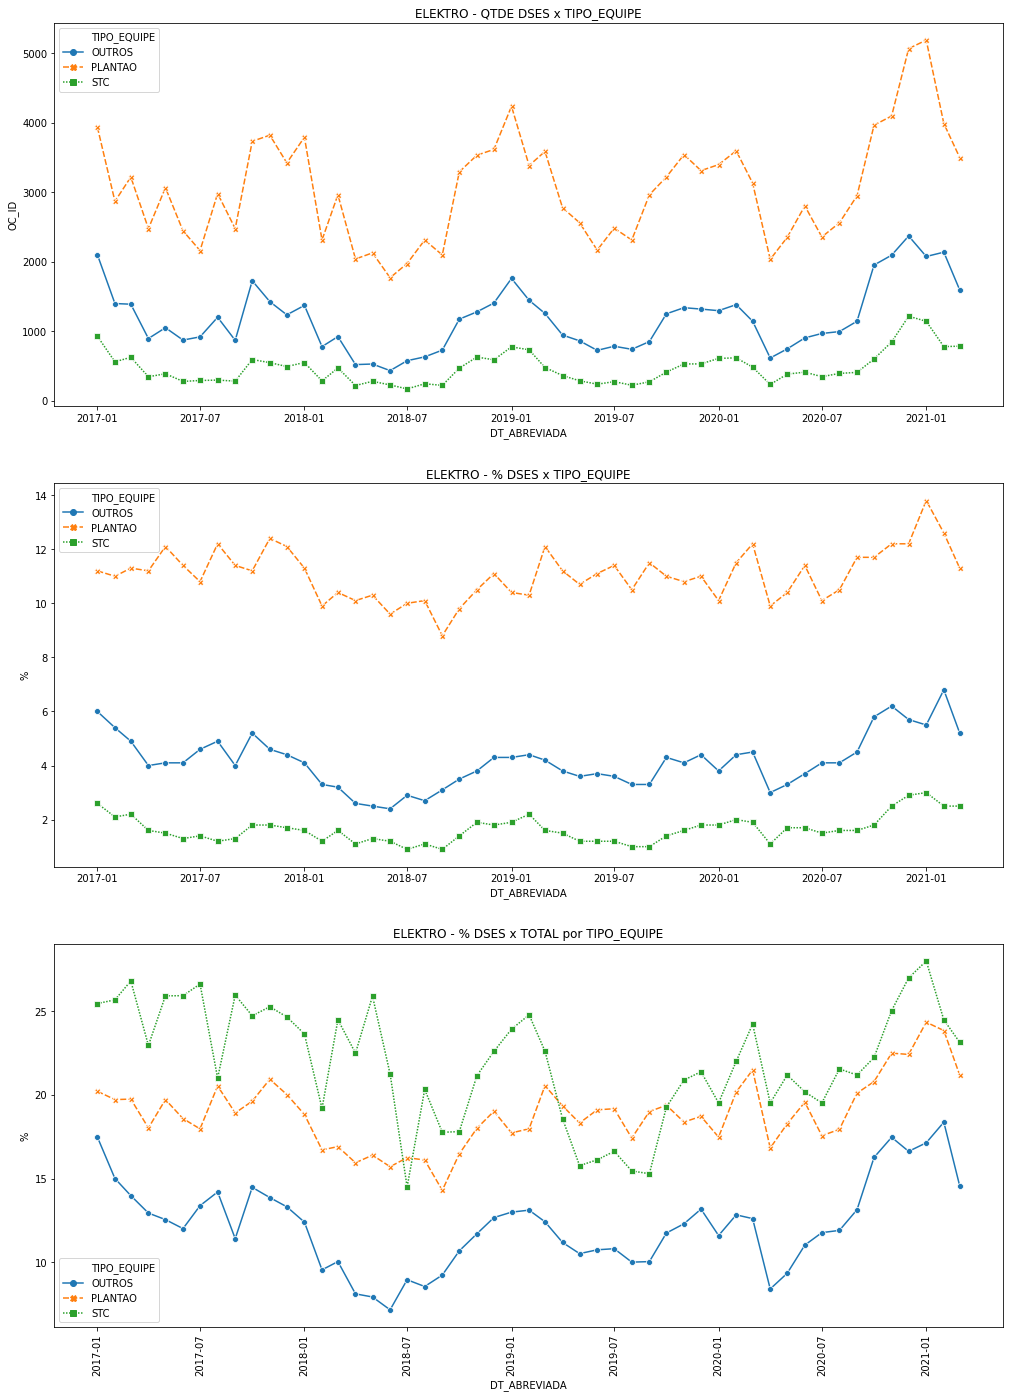

In [183]:
# DSES por TIPO DE EQUIPE - ELEKTRO INTEIRA - APROXIMAÇÃO

df = oc_elektro1.sort_values(['DT_ABREVIADA','TIPO_EQUIPE'],ascending = [True,True])

improd = pd.DataFrame()
total = pd.DataFrame() 
for i in df['DT_ABREVIADA'].unique():
    # total
    dd = df.loc[df['DT_ABREVIADA'] == i]
    dd = dd.groupby(['DT_ABREVIADA'],as_index = False)['OC_ID'].count()
    total = pd.concat([total,dd], axis = 0 ,ignore_index = True)
    
    # improd
    dd1 = df.loc[(df['DT_ABREVIADA'] == i)&(df['DSES'] == 'S')]
    dd1 = dd1.groupby(['DT_ABREVIADA','TIPO_EQUIPE'],as_index = False)['OC_ID'].count()
    dd1['%'] = round( 100 * dd1['OC_ID']/dd['OC_ID'].sum(),1)

    improd = pd.concat([improd,dd1], axis = 0 ,ignore_index = True)

dados = pd.DataFrame()
total = pd.DataFrame() 
for i in df['DT_ABREVIADA'].unique():
    for j in df['TIPO_EQUIPE'].unique():
        # prod
        dados_p = df.loc[(df['DT_ABREVIADA'] == i)&
                         (df['TIPO_EQUIPE'] == j)]
        dados_p = dados_p.groupby(['DT_ABREVIADA','TIPO_EQUIPE'],as_index = False)['OC_ID'].count()

        # improd
        dados_i = df.loc[(df['DT_ABREVIADA'] == i)&
                         (df['DSES'] == 'S')&
                         (df['TIPO_EQUIPE'] == j)]
        dados_i = dados_i.groupby(['DT_ABREVIADA','TIPO_EQUIPE'],as_index = False)['OC_ID'].count()
        dados = pd.concat([dados_p,dados_i['OC_ID']], axis = 1, ignore_index = True)
        total = pd.concat([total,dados], axis = 0, ignore_index = True)
total.columns = ['DT_ABREVIADA','TIPO_EQUIPE','TOTAL','IMPRODUTIVO']
total['%'] = 100*total['IMPRODUTIVO']/total['TOTAL']

#=======================================================================   
fig, axes = plt.subplots(3,1,figsize=(17,24))

sns.lineplot(x = 'DT_ABREVIADA', y = 'OC_ID', data = improd,hue = 'TIPO_EQUIPE',
             style = 'TIPO_EQUIPE',ax = axes[0],markers=True) 
axes[0].set_title('ELEKTRO - QTDE DSES x TIPO_EQUIPE')
# for i in improd.index:
#     if improd['PERIODO_RECLAMACAO'][i] == '12h as 17:59h':
#         axes[0].annotate(str(improd['OC_ID'][i]),
#                      xy=(improd['DT_ABREVIADA'][i], improd['OC_ID'][i]),
#                      xytext=(improd['DT_ABREVIADA'][i], improd['OC_ID'][i] + 0.02*improd['OC_ID'][i]),
#                      fontsize = 11.5,rotation = 65)

sns.lineplot(x = 'DT_ABREVIADA', y = '%', data = improd,hue = 'TIPO_EQUIPE',
             style = 'TIPO_EQUIPE',ax = axes[1],markers=True)
axes[1].set_title('ELEKTRO - % DSES x TIPO_EQUIPE')
# for i in improd.index:
#     if improd['PERIODO_RECLAMACAO'][i] == '12h as 17:59h':
#         axes[1].annotate(str(improd['%'][i]),
#                      xy=(improd['DT_ABREVIADA'][i], improd['%'][i]),
#                      xytext=(improd['DT_ABREVIADA'][i], improd['%'][i] + 0.05*improd['%'][i]),
#                      fontsize = 11.5,rotation = 65)
sns.lineplot(x = 'DT_ABREVIADA', y = '%', data = total,hue = 'TIPO_EQUIPE',
             style = 'TIPO_EQUIPE',ax = axes[2],markers=True)
axes[2].set_title('ELEKTRO - % DSES x TOTAL por TIPO_EQUIPE')

plt.xticks(rotation = 90)
plt.show()

### PARTE 3

#### GERAL TIPO DE ATENDIMENTO X IMPRODUTIVAS

In [184]:
origem_canal['CANAL_ATENDIMENTO'].unique()

array(['DIGITAL', 'HUMANO'], dtype=object)

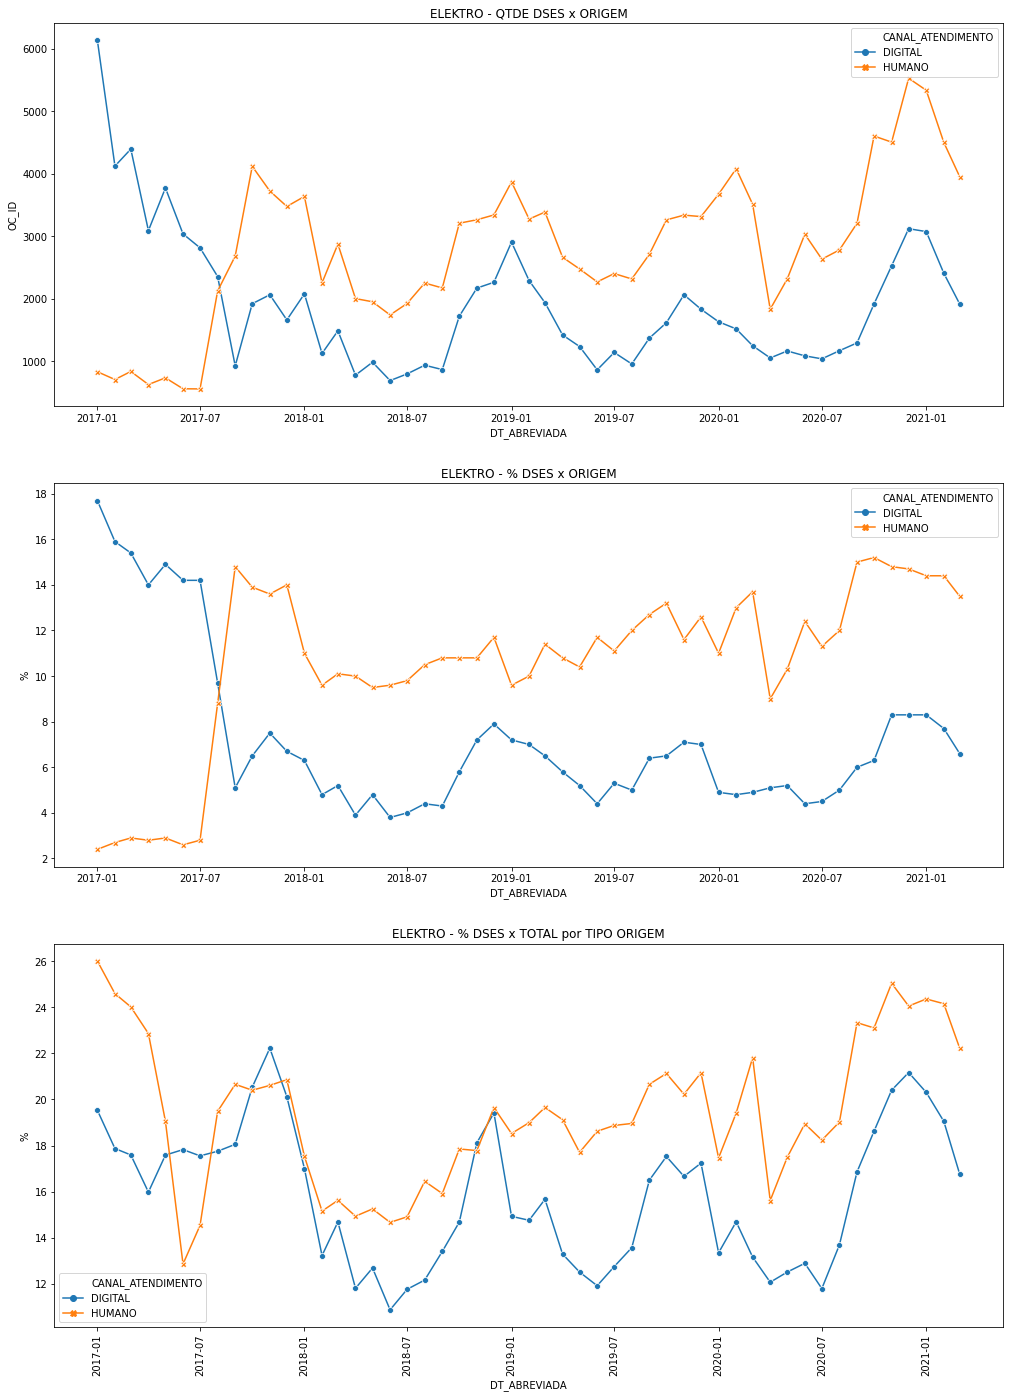

In [185]:
# DSES por CANAL

df = oc_elektro.sort_values(['DT_ABREVIADA','CANAL_ATENDIMENTO'],ascending = [True,True])
df = df.loc[~df['CANAL_ATENDIMENTO'].isna()]

improd = pd.DataFrame()
total = pd.DataFrame() 
for i in df['DT_ABREVIADA'].unique():
    # total
    dd = df.loc[df['DT_ABREVIADA'] == i]
    dd = dd.groupby(['DT_ABREVIADA'],as_index = False)['OC_ID'].count()
    total = pd.concat([total,dd], axis = 0 ,ignore_index = True)
    
    # improd
    dd1 = df.loc[(df['DT_ABREVIADA'] == i)&(df['DSES'] == 'S')]
    dd1 = dd1.groupby(['DT_ABREVIADA','CANAL_ATENDIMENTO'],as_index = False)['OC_ID'].count()
    dd1['%'] = round( 100 * dd1['OC_ID']/dd['OC_ID'].sum(),1)

    improd = pd.concat([improd,dd1], axis = 0 ,ignore_index = True)

dados = pd.DataFrame()
total = pd.DataFrame() 
for i in df['DT_ABREVIADA'].unique():
    for j in df['CANAL_ATENDIMENTO'].unique():
        # prod
        dados_p = df.loc[(df['DT_ABREVIADA'] == i)&
                         (df['CANAL_ATENDIMENTO'] == j)]
        dados_p = dados_p.groupby(['DT_ABREVIADA','CANAL_ATENDIMENTO'],as_index = False)['OC_ID'].count()

        # improd
        dados_i = df.loc[(df['DT_ABREVIADA'] == i)&
                         (df['DSES'] == 'S')&
                         (df['CANAL_ATENDIMENTO'] == j)]
        dados_i = dados_i.groupby(['DT_ABREVIADA','CANAL_ATENDIMENTO'],as_index = False)['OC_ID'].count()
        dados = pd.concat([dados_p,dados_i['OC_ID']], axis = 1, ignore_index = True)
        total = pd.concat([total,dados], axis = 0, ignore_index = True)
total.columns = ['DT_ABREVIADA','CANAL_ATENDIMENTO','TOTAL','IMPRODUTIVO']
total['%'] = 100*total['IMPRODUTIVO']/total['TOTAL']

#=======================================================================   
fig, axes = plt.subplots(3,1,figsize=(17,24))

sns.lineplot(x = 'DT_ABREVIADA', y = 'OC_ID', data = improd,hue = 'CANAL_ATENDIMENTO',
             style = 'CANAL_ATENDIMENTO',ax = axes[0],markers=True, dashes = False) 
axes[0].set_title('ELEKTRO - QTDE DSES x ORIGEM')
# for i in improd.index:
#     if improd['PERIODO_RECLAMACAO'][i] == '12h as 17:59h':
#         axes[0].annotate(str(improd['OC_ID'][i]),
#                      xy=(improd['DT_ABREVIADA'][i], improd['OC_ID'][i]),
#                      xytext=(improd['DT_ABREVIADA'][i], improd['OC_ID'][i] + 0.02*improd['OC_ID'][i]),
#                      fontsize = 11.5,rotation = 65)

sns.lineplot(x = 'DT_ABREVIADA', y = '%', data = improd,hue = 'CANAL_ATENDIMENTO',
             style = 'CANAL_ATENDIMENTO',ax = axes[1],markers=True, dashes = False)
axes[1].set_title('ELEKTRO - % DSES x ORIGEM')
# for i in improd.index:
#     if improd['PERIODO_RECLAMACAO'][i] == '12h as 17:59h':
#         axes[1].annotate(str(improd['%'][i]),
#                      xy=(improd['DT_ABREVIADA'][i], improd['%'][i]),
#                      xytext=(improd['DT_ABREVIADA'][i], improd['%'][i] + 0.05*improd['%'][i]),
#                      fontsize = 11.5,rotation = 65)
sns.lineplot(x = 'DT_ABREVIADA', y = '%', data = total,hue = 'CANAL_ATENDIMENTO',
             style = 'CANAL_ATENDIMENTO',ax = axes[2],markers=True, dashes = False)
axes[2].set_title('ELEKTRO - % DSES x TOTAL por TIPO ORIGEM')

plt.xticks(rotation = 90)
plt.show()

#### RELACIONAMENTO - DSES X EQUIPES QUE MAIS ONERAM 

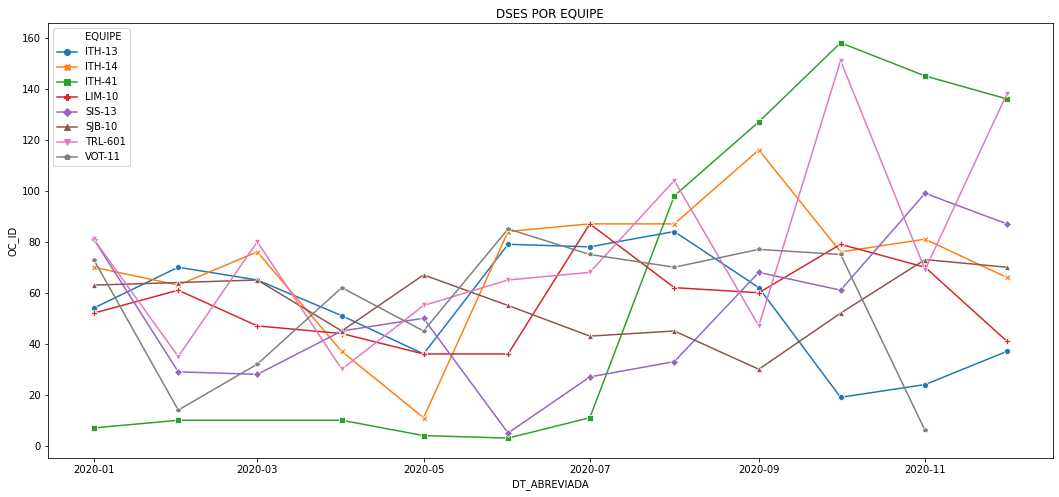

In [90]:
# SUMARIZAR POR TIPO DE EQUIPE
dses_equipe = oc_elektro.loc[(oc_elektro['DSES'] == 'S')&(oc_elektro['ANO'] == 2020)]
dses_equipe_agg = dses_equipe.groupby(['DT_ABREVIADA','EQUIPE'],as_index = False)['OC_ID'].count()


# PEGAR AS 8 MAIS ONEROSAS POR EQUIPE E TIPO
p1 = dses_equipe['EQUIPE'].value_counts().index[:8]


# PLOTAR FIGURA
fig, axes = plt.subplots(1,1,figsize=(18,8))

ep1 = dses_equipe_agg.loc[dses_equipe_agg['EQUIPE'].isin(p1)]
sns.lineplot(x = 'DT_ABREVIADA', y = 'OC_ID', data = ep1, hue = 'EQUIPE',
             style = 'EQUIPE', ax = axes, markers=True, dashes = False)
axes.set_title('DSES POR EQUIPE')


plt.show()

# plantao: 10 A 19
# STC: 3 DIGITOS (INICIA COM 6)
# EQUIPES QUE INICIAM COM 2: DIGGER, GUINDAUTO, (CAMINHOES PESADOS)... pode ter equipe de poda (preventiva)
# equipes que iniciam com 3: equipes de obras (cesta aerea) (linha morta)
# equipes que iniciam com 4: cesta aerea linha viva
# confirmar se as equipes de obras permanecem com 2 letras no prefixo

In [ ]:
dses_equipe['EQUIPE'].value_counts().head(15)

In [ ]:
# DSES POR EQUIPE SUMARIZADO POR GERENCIA

def exemplo(df1,gerencia):
    dses_equipe = oc_elektro.loc[(oc_elektro['DSES'] == 'S')&(oc_elektro['ANO'] == 2020)&
                                (oc_elektro['GERENCIA'] == gerencia)]
    dses_equipe_agg = dses_equipe.groupby(['DT_ABREVIADA','EQUIPE'],as_index = False)['OC_ID'].count()


    # PEGAR AS 5 MAIS ONEROSAS POR EQUIPE E TIPO
    p1 = dses_equipe['EQUIPE'].value_counts().index[:5]

    # PLOTAR FIGURA
    fig, axes = plt.subplots(1,1,figsize=(18,8))

    ep1 = dses_equipe_agg.loc[dses_equipe_agg['EQUIPE'].isin(p1)]
    sns.lineplot(x = 'DT_ABREVIADA', y = 'OC_ID', data = ep1, hue = 'EQUIPE',
                 style = 'EQUIPE', ax = axes, markers=True, dashes = False)
    axes.set_title('DSES POR EQUIPE - ' + gerencia)
    plt.ylim([0,160])
    plt.show()
#===================================================================================
#===================================================================================
#===================================================================================
btn_ger = widgets.Dropdown(
options = np.sort(oc_elektro['GERENCIA'].unique()),
value = oc_elektro['GERENCIA'].iat[0],
description = 'GERENCIA:',
disable = False)


# WIDGET CREATED 
widgets.interactive(exemplo ,df1 = fixed( oc_elektro ), gerencia = btn_ger )

#### CALCULO ENTRE A DISTANCIA DA BOP X OC

In [ ]:
elektro_lat = oc_elektro['LATITUDE'].to_numpy()
elektro_long = oc_elektro['LONGITUDE'].to_numpy()
bop_lat = bases_elektro['LATITUDE'].to_numpy()
bop_long = bases_elektro['LONGITUDE'].to_numpy()
bop_loc = bases_elektro['LOCALIDADE'].to_numpy()
# bop_end = bases_elektro['ENDERECO'].values

dist_bop = np.full(elektro_lat.shape, np.nan, dtype='float')
bop_lat_chosen = np.full(elektro_lat.shape, np.nan, dtype='float')
bop_lon_chosen = np.full(elektro_lat.shape, np.nan, dtype='float')
bop_loc_chosen = np.full(elektro_lat.shape, np.nan, dtype='object')
# bop_end_chosen = np.full(elektro_lat.shape, np.nan, dtype='object')
 
for i,j in enumerate(elektro_lat):
    for k,l in enumerate(bop_lat):
        if k == 0:
            dist_bop[i] = distancia_2_coordenadas(elektro_lat[i],elektro_long[i],bop_lat[k],bop_long[k])
            bop_lat_chosen[i] = bop_lat[k]
            bop_lon_chosen[i] = bop_long[k]
            bop_loc_chosen[i] = bop_loc[k]
#             bop_end_chosen[i] = bop_end[k]
        else:
            a = distancia_2_coordenadas(elektro_lat[i],elektro_long[i],bop_lat[k],bop_long[k])
            if a < dist_bop[i]:
                dist_bop[i] = a
                bop_lat_chosen[i] = bop_lat[k]
                bop_lon_chosen[i] = bop_long[k]
                bop_loc_chosen[i] = bop_loc[k]
#                 bop_end_chosen[i] = bop_end[k]

oc_elektro['DIST_BOP'] = dist_bop
oc_elektro['LAT_BOP'] = bop_lat_chosen
oc_elektro['LON_BOP'] = bop_lon_chosen
oc_elektro['LOCAL_BOP'] = bop_loc_chosen
# oc_elektro['ENDERECO_BOP'] = bop_end_chosen

In [ ]:
# from dask.distributed import Client
# import dask
# client = Client()

# @dask.delayed
# def exemplo_dask():
#     elektro_lat = oc_elektro['LATITUDE'].to_numpy()
#     elektro_long = oc_elektro['LONGITUDE'].to_numpy()
#     bop_lat = bases_elektro['LATITUDE'].to_numpy()
#     bop_long = bases_elektro['LONGITUDE'].to_numpy()
#     bop_loc = bases_elektro['LOCALIDADE'].to_numpy()
#     # bop_end = bases_elektro['ENDERECO'].values

#     dist_bop = np.full(elektro_lat.shape, np.nan, dtype='float')
#     bop_lat_chosen = np.full(elektro_lat.shape, np.nan, dtype='float')
#     bop_lon_chosen = np.full(elektro_lat.shape, np.nan, dtype='float')
#     bop_loc_chosen = np.full(elektro_lat.shape, np.nan, dtype='object')
#     # bop_end_chosen = np.full(elektro_lat.shape, np.nan, dtype='object')

#     for i,j in enumerate(elektro_lat):
#         for k,l in enumerate(bop_lat):
#             if k == 0:
#                 dist_bop[i] = distancia_2_coordenadas(elektro_lat[i],elektro_long[i],bop_lat[k],bop_long[k])
#                 bop_lat_chosen[i] = bop_lat[k]
#                 bop_lon_chosen[i] = bop_long[k]
#                 bop_loc_chosen[i] = bop_loc[k]
#     #             bop_end_chosen[i] = bop_end[k]
#             else:
#                 a = distancia_2_coordenadas(elektro_lat[i],elektro_long[i],bop_lat[k],bop_long[k])
#                 if a < dist_bop[i]:
#                     dist_bop[i] = a
#                     bop_lat_chosen[i] = bop_lat[k]
#                     bop_lon_chosen[i] = bop_long[k]
#                     bop_loc_chosen[i] = bop_loc[k]
#     #                 bop_end_chosen[i] = bop_end[k]
#     return dist_bop


# distancia = dask.delayed(exemplo_dask)()

# distancia.compute()

In [ ]:
# 5m 48s
(2*60+50) / (5*60 + 48)

#### PARETO E BOXPLOT DAS DISTANCIAS NOS SETORES E UTDS

In [ ]:
plot_pareto('DSES 2020 POR SETOR', oc_elektro.loc[(oc_elektro['DSES'] == 'S')&
                            (oc_elektro['ANO'] == 2020)], 
            'GERENCIA', 'OC_ID',var='count')

In [ ]:
b = oc_elektro[['GERENCIA','OC_ID']].loc[(oc_elektro['DSES'] == 'S')&
               (oc_elektro['ANO'] == 2020)].copy()
setores = b['GERENCIA'].value_counts().index
setores

In [ ]:
# oc_elektro = oc_elektro.loc[oc_elektro['LATITUDE']> -90]
# oc_elektro = oc_elektro.loc[oc_elektro['LONGITUDE']> -90]

fig, axes = plt.subplots(2,1,figsize=(18,22))

a = oc_elektro.loc[#(elektro['STATUS_DESLOCAMENTO'] == 'IMPRODUTIVO')&
                            (oc_elektro['ANO'] == 2020)].sort_values('UTD').copy()
a = a.loc[a['LATITUDE']> -90]
a = a.loc[a['LONGITUDE']> -90]
a = a.loc[a['DIST_BOP'] <= 80]

a['ordem'] = a['GERENCIA'].apply(lambda x:0 if x=='CANTAREIRA' else 1 if x=='POLO DAS INDUSTRIAS' else
2 if x=='LITORAL SUL' else 3 if x=='NORTE PAULISTA' else 4 if x=='LESTE PAULISTA' else
5 if x=='OESTE PAULISTA' else 6 if x=='POLO CERAMICO' else 7 if x=='ALTA PAULISTA' else
8 if x=='VALE DO RIBEIRA' else 9 if x=='MEDIO TIETE'else 10 if x== 'SUDOESTE PAULISTA' else 11)
a = a.sort_values('ordem')


sns.boxplot(y = a['DIST_BOP'],x = a['GERENCIA'], data = a, hue = 'DSES',ax = axes[0])
sns.boxplot(y = a['DIST_BOP'],x = a['UTD'], data = a, hue = 'DSES',ax = axes[1])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90, horizontalalignment='right')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90, horizontalalignment='right')
fig.tight_layout()
plt.show()

#### TESTE T -  DSES X PRODUTIVOS

In [ ]:
# TESTE t 

improd = pd.DataFrame()
prod = pd.DataFrame() 
total = pd.DataFrame()
df = oc_elektro.loc[oc_elektro['ANO'] == 2020].copy()
for i in df['DT_ABREVIADA'].unique():
    for j in df['GERENCIA'].unique():
    # total
        dd = df.loc[(df['DT_ABREVIADA'] == i)&(df['DSES'] == 'N')&
                   (df['GERENCIA'] == j)]
        dd = dd.groupby(['DT_ABREVIADA','GERENCIA'],as_index = False)['DIST_BOP'].mean()
        dd.columns = ['DT_ABREVIADA','GERENCIA','PRODUTIVO']
        # improd
        dd1 = df.loc[(df['DT_ABREVIADA'] == i)&(df['DSES'] == 'S')&
                   (df['GERENCIA'] == j)]
        dd1 = dd1.groupby(['DT_ABREVIADA','GERENCIA'],as_index = False)['DIST_BOP'].mean()
        dd1.columns = ['DT_ABREVIADA','GERENCIA','IMPRODUTIVO']
        d = pd.concat([dd,dd1['IMPRODUTIVO']], axis = 1 ,ignore_index = True)
        total = pd.concat([total, d], axis = 0 ,ignore_index = True)
total.columns = ['DT_ABREVIADA','GERENCIA','PRODUTIVO','IMPRODUTIVO']

# TWO-SIDED
for i in total['GERENCIA'].unique():
    df = total.loc[total['GERENCIA'] == i]

    a = df['PRODUTIVO'].to_numpy()
    b = df['IMPRODUTIVO'].to_numpy()
    
    teste_t = stats.ttest_ind(a,b,equal_var = False, alternative = 'two-sided')
    print('\nTeste t para ' + i,'\nvalor t:',teste_t.statistic,'  valor p:',teste_t.pvalue)

print('\n')
# ONE-SIDED
for i in total['GERENCIA'].unique():
    df = total.loc[total['GERENCIA'] == i]

    a = df['PRODUTIVO'].to_numpy()
    b = df['IMPRODUTIVO'].to_numpy()
    
    teste_t = stats.ttest_ind(a,b,equal_var = False, alternative = 'less')
    print('\nTeste t para ' + i,'\nvalor t:',teste_t.statistic,'  valor p:',teste_t.pvalue)

#### MAPA INTERATIVO

In [ ]:
np.sort(bases_elektro['LOCALIDADE'].unique())

In [ ]:
ekt_improd = oc_elektro.loc[oc_elektro['DSES'] == 'S']
ekt_improd = ekt_improd.loc[ekt_improd['ANO'] == 2020]
ekt_improd = ekt_improd.loc[~ekt_improd['LATITUDE'].isna()]
# LESTE
ekt_improd = ekt_improd.loc[ekt_improd['GERENCIA'].isin(['LESTE PAULISTA','CANTAREIRA',
                                                         'VALE DO PARAIBA'])]
# # OESTE
# ekt_improd = ekt_improd.loc[ekt_improd['GERENCIA'].isin(['OESTE PAULISTA', 'ALTA PAULISTA',
#                                                          'NORTE PAULISTA'])]
# # CENTRO
# ekt_improd = ekt_improd.loc[ekt_improd['GERENCIA'].isin(['POLO CERAMICO', 
#                                                          'POLO DAS INDUSTRIAS', 'MEDIO TIETE'])]
# # SUL
# ekt_improd = ekt_improd.loc[ekt_improd['GERENCIA'].isin(['LITORAL SUL', 'SUDOESTE PAULISTA',
#                                                          'VALE DO RIBEIRA'])]


ekt_improd = ekt_improd.loc[ekt_improd['CAUSA'].isin(['RESPONSABILIDADE DO CLIENTE',
    'RECLAMAÇÃO IMPROCEDENTE','OUTRAS CAUSAS','ALHEIO À ELEKTRO','INF. INSUFICIENTES P/  LOCALIZAÇÃO'])]

ekt_improd.loc[ekt_improd['CAUSA']=='RESPONSABILIDADE DO CLIENTE','cor'] = 'red'
ekt_improd.loc[ekt_improd['CAUSA']=='RECLAMAÇÃO IMPROCEDENTE','cor'] = 'black'
ekt_improd.loc[ekt_improd['CAUSA']=='OUTRAS CAUSAS','cor'] = 'green'
ekt_improd.loc[ekt_improd['CAUSA']=='ALHEIO À ELEKTRO','cor'] = 'blue'
ekt_improd.loc[ekt_improd['CAUSA']=='INF. INSUFICIENTES P/  LOCALIZAÇÃO','cor'] = 'purple'

In [ ]:
# # TESTE MAPA COM TUDO
# mapa = mapa_folium(ekt_improd,'CAUSA')
# LESTE
# mapa.save(caminho + 'ELEKTRO_DSES_LESTE_v2.html')
#OESTE
# mapa.save(caminho + 'ELEKTRO_DSES_OESTE.html')
#CENTRO
# mapa.save(caminho + 'ELEKTRO_DSES_CENTRO.html')
#SUL
# mapa.save(caminho + 'ELEKTRO_DSES_SUL.html')

In [ ]:
ekt_improd.loc[ekt_improd['LOCAL_BOP'].isin(['SETE BARRAS','MOGI-GUACU','ANDRADINA',
         'MIRACATU', 'INDIAPORA', 'RIO CLARO'])]

In [ ]:
ekt_improd.shape

#### CLIMA X DSES

In [ ]:
oc_elektro['chave'] = oc_elektro['LOCALIDADE'] + '-' + oc_elektro['DT_RECLAMACAO'].dt.strftime('%d-%m-%Y').astype(str)
clima_elektro['chave'] = clima_elektro['LOCALIDADE'] + '-' + clima_elektro['DT_ABREVIADA'].dt.strftime('%d-%m-%Y').astype(str)
oc_elektro = oc_elektro.merge(clima_elektro[['chave','PRECIPITACAO','T_MAX','T_MIN','T_MED']],
                      on = 'chave', how = 'left')
oc_elektro = oc_elektro.drop('chave', axis = 1)

In [ ]:
# REL CLIMA X DSES COSERN

df = oc_elektro.sort_values('DT_ABREVIADA',ascending = True)
df = df.loc[(df['DSES'] == 'S')]

df = df.groupby('DT_ABREVIADA',as_index = False).agg({'DSES':'count',
                                                     'PRECIPITACAO':'mean'})


fig, axes = plt.subplots(1,1,figsize=(17,8))

dses = axes.plot(df['DT_ABREVIADA'], df['DSES'], color="C2",marker="D",label = 'DSES')
axes.set_title('ELEKTRO - REL CLIMA x DSES')
axes.legend(loc=0)

axes2 = axes.twinx()
precip = axes2.plot(df['DT_ABREVIADA'], df['PRECIPITACAO'], color="C1", marker="D",label = 'PRECIPITACAO')
axes2.set_ylim([0,df['PRECIPITACAO'].max()])

lns = dses + precip
labs = [l.get_label() for l in lns]
axes.legend(lns, labs, loc=0)
plt.xticks(rotation = 90)
plt.show()

In [ ]:
# REL CLIMA X DSES LOCALIDADE ATENDIDA

def exemplo(df1,localidade):
    df = df1.sort_values('DT_ABREVIADA',ascending = True)
    df = df.loc[(df['LOCALIDADE'] == localidade) & (df['DSES'] == 'S')]
    
    df = df.groupby('DT_ABREVIADA',as_index = False).agg({'DSES':'count',
                                                         'PRECIPITACAO':'mean'})

 
    fig, axes = plt.subplots(1,1,figsize=(17,8))

    dses = axes.plot(df['DT_ABREVIADA'], df['DSES'], color="C2",marker="D",label = 'DSES')
    axes.set_title(localidade + ' - REL CLIMA x DSES')
    axes.legend(loc=0)
    
    axes2 = axes.twinx()
    precip = axes2.plot(df['DT_ABREVIADA'], df['PRECIPITACAO'], color="C1", marker="D",label = 'PRECIPITACAO')
    axes2.set_ylim([0,df['PRECIPITACAO'].max()])
    
    lns = dses + precip
    labs = [l.get_label() for l in lns]
    axes.legend(lns, labs, loc=0)
    plt.xticks(rotation = 90)
    plt.show()
#===================================================================================
#===================================================================================
#===================================================================================
btn_localidade = widgets.Dropdown(
options = np.sort(oc_elektro['LOCALIDADE'].unique()),
value = oc_elektro['LOCALIDADE'].iat[0],
description = 'LOCALIDADE:',
disable = False)


# WIDGET CREATED 
widgets.interactive(exemplo ,df1 = fixed( oc_elektro ), localidade = btn_localidade )

In [ ]:
# PLOTAR A CORRELAÇÃO ENTRE PRECIPITAÇÃO X % DSES

oc_elektro['DIA'] = pd.to_datetime(oc_elektro['DT_RECLAMACAO'].dt.strftime('%d-%m-%Y'),format='%d-%m-%Y')
df = oc_elektro.sort_values('DT_ABREVIADA',ascending = True)
df = df.loc[df['DIA_SEMANA'].isin(['SEGUNDA-FEIRA', 'TERCA-FEIRA',
                                   'QUARTA-FEIRA', 'QUINTA-FEIRA',
                                    'SEXTA-FEIRA'])]
d = pd.DataFrame()
for i in df['DIA'].unique():
    # total
    dd = df.loc[df['DIA'] == i]
    dd = dd.groupby(['DIA'],as_index = False).agg({'OC_ID':'count',
                                                          'PRECIPITACAO':'mean'})

    # improd
    dd1 = df.loc[(df['DIA'] == i)&(df['DSES'] == 'S')]
    dd1 = dd1.groupby(['DIA'],as_index = False).agg({'OC_ID':'count',
                                                          'PRECIPITACAO':'mean'})

    dd2 = pd.concat([dd,dd1['OC_ID']], axis = 1 ,ignore_index = True)

    d = pd.concat([d,dd2], axis = 0 ,ignore_index = True)
d = d.reset_index(drop = True)
d.columns = ['DIA','OC_ID','PRECIPITACAO','IMPRODUTIVO']
d['%'] = round( 100 * d['IMPRODUTIVO']/d['OC_ID'],1)

#====================================================================
plt.figure(figsize=(15,8))
plt.scatter(x = d['%'],y = d['PRECIPITACAO'])
plt.title('CORRELAÇÃO ENTRE    PRECIPITAÇÃO   x   % DSES')
plt.xlabel(' % DSES')
plt.ylabel('PRECIPITACAO')
plt.show()

In [ ]:
correlacao = d[['%','PRECIPITACAO']].corr()
correlacao

In [ ]:
correlacao1 = d[['OC_ID','PRECIPITACAO']].corr()
correlacao1

#### RELACIONAMENTO - DSES X TIPO de LOCALIZAÇÃO (RR | UB)

In [ ]:
# DSES por TIPO DE LOCALIZACAO - CELPE INTEIRA

df = oc_elektro.sort_values(['DT_ABREVIADA','LOCALIZACAO'],ascending = [True,True])

improd = pd.DataFrame()
total = pd.DataFrame() 
for i in df['DT_ABREVIADA'].unique():
    # total
    dd = df.loc[df['DT_ABREVIADA'] == i]
    dd = dd.groupby(['DT_ABREVIADA'],as_index = False)['OC_ID'].count()
    total = pd.concat([total,dd], axis = 0 ,ignore_index = True)
    
    # improd
    dd1 = df.loc[(df['DT_ABREVIADA'] == i)&(df['DSES'] == 'S')]
    dd1 = dd1.groupby(['DT_ABREVIADA','LOCALIZACAO'],as_index = False)['OC_ID'].count()
    dd1['%'] = round( 100 * dd1['OC_ID']/dd['OC_ID'].sum(),1)

    improd = pd.concat([improd,dd1], axis = 0 ,ignore_index = True)

dados = pd.DataFrame()
total = pd.DataFrame() 
for i in df['DT_ABREVIADA'].unique():
    for j in df['LOCALIZACAO'].unique():
        # prod
        dados_p = df.loc[(df['DT_ABREVIADA'] == i)&
                         (df['LOCALIZACAO'] == j)]
        dados_p = dados_p.groupby(['DT_ABREVIADA','LOCALIZACAO'],as_index = False)['OC_ID'].count()

        # improd
        dados_i = df.loc[(df['DT_ABREVIADA'] == i)&
                         (df['DSES'] == 'S')&
                         (df['LOCALIZACAO'] == j)]
        dados_i = dados_i.groupby(['DT_ABREVIADA','LOCALIZACAO'],as_index = False)['OC_ID'].count()
        dados = pd.concat([dados_p,dados_i['OC_ID']], axis = 1, ignore_index = True)
        total = pd.concat([total,dados], axis = 0, ignore_index = True)
total.columns = ['DT_ABREVIADA','LOCALIZACAO','TOTAL','IMPRODUTIVO']
total['%'] = 100*total['IMPRODUTIVO']/total['TOTAL']

#=======================================================================   
fig, axes = plt.subplots(3,1,figsize=(17,24))

sns.lineplot(x = 'DT_ABREVIADA', y = 'OC_ID', data = improd,hue = 'LOCALIZACAO',
             style = 'LOCALIZACAO',ax = axes[0],markers=True) 
axes[0].set_title('ELEKTRO - QTDE DSES x LOCALIZACAO')
# for i in improd.index:
#     if improd['PERIODO_RECLAMACAO'][i] == '12h as 17:59h':
#         axes[0].annotate(str(improd['OC_ID'][i]),
#                      xy=(improd['DT_ABREVIADA'][i], improd['OC_ID'][i]),
#                      xytext=(improd['DT_ABREVIADA'][i], improd['OC_ID'][i] + 0.02*improd['OC_ID'][i]),
#                      fontsize = 11.5,rotation = 65)

sns.lineplot(x = 'DT_ABREVIADA', y = '%', data = improd,hue = 'LOCALIZACAO',
             style = 'LOCALIZACAO',ax = axes[1],markers=True)
axes[1].set_title('ELEKTRO - % DSES x LOCALIZACAO')
# for i in improd.index:
#     if improd['PERIODO_RECLAMACAO'][i] == '12h as 17:59h':
#         axes[1].annotate(str(improd['%'][i]),
#                      xy=(improd['DT_ABREVIADA'][i], improd['%'][i]),
#                      xytext=(improd['DT_ABREVIADA'][i], improd['%'][i] + 0.05*improd['%'][i]),
#                      fontsize = 11.5,rotation = 65)
sns.lineplot(x = 'DT_ABREVIADA', y = '%', data = total,hue = 'LOCALIZACAO',
             style = 'LOCALIZACAO',ax = axes[2],markers=True)
axes[2].set_title('ELEKTRO - % DSES x TOTAL por TIPO LOCALIZACAO')

plt.xticks(rotation = 90)
plt.show()

In [ ]:
# # DSES por TIPO DE LOCALIZACAO - CELPE POR EQUIPE e POR EMPRESA

# def exemplo(df1,empresa,equipe,sn):
#     # DSES por TIPO DE LOCALIZACAO - CELPE INTEIRA
#     df = df1.sort_values('DT_ABREVIADA',ascending = True)
#     df = df.loc[df['TIPO_EMPRESA'] == empresa]
#     if sn == 'SIM':
#         df = df.loc[df['TIPO_PROCESSO'] == equipe]
#     else:
#         pass
        

#     improd = pd.DataFrame()
#     total = pd.DataFrame() 
#     for i in df['DT_ABREVIADA'].unique():
#         # total
#         dd = df.loc[df['DT_ABREVIADA'] == i]
#         dd = dd.groupby(['DT_ABREVIADA'],as_index = False)['OC_ID'].count()
#         total = pd.concat([total,dd], axis = 0 ,ignore_index = True)

#         # improd
#         dd1 = df.loc[(df['DT_ABREVIADA'] == i)&(df['STATUS_DESLOCAMENTO'] == 'IMPRODUTIVO')]
#         dd1 = dd1.groupby(['DT_ABREVIADA','LOCALIZACAO'],as_index = False)['OC_ID'].count()
#         dd1['%'] = round( 100 * dd1['OC_ID']/dd['OC_ID'].sum(),1)

#         improd = pd.concat([improd,dd1], axis = 0 ,ignore_index = True)


#     #=======================================================================   
#     fig, axes = plt.subplots(2,1,figsize=(17,16))

#     sns.lineplot(x = 'DT_ABREVIADA', y = 'OC_ID', data = improd,hue = 'LOCALIZACAO',
#                  style = 'LOCALIZACAO',ax = axes[0],markers=True) 
#     axes[0].set_title('CELPE - QTDE IMPRODUTIVOS x LOCALIZACAO - ' + empresa)
#     # for i in improd.index:
#     #     if improd['PERIODO_RECLAMACAO'][i] == '12h as 17:59h':
#     #         axes[0].annotate(str(improd['OC_ID'][i]),
#     #                      xy=(improd['DT_ABREVIADA'][i], improd['OC_ID'][i]),
#     #                      xytext=(improd['DT_ABREVIADA'][i], improd['OC_ID'][i] + 0.02*improd['OC_ID'][i]),
#     #                      fontsize = 11.5,rotation = 65)

#     sns.lineplot(x = 'DT_ABREVIADA', y = '%', data = improd,hue = 'LOCALIZACAO',
#                  style = 'LOCALIZACAO',ax = axes[1],markers=True)
#     axes[1].set_title('CELPE - % IMPRODUTIVOS x LOCALIZACAO - ' + empresa)
#     # for i in improd.index:
#     #     if improd['PERIODO_RECLAMACAO'][i] == '12h as 17:59h':
#     #         axes[1].annotate(str(improd['%'][i]),
#     #                      xy=(improd['DT_ABREVIADA'][i], improd['%'][i]),
#     #                      xytext=(improd['DT_ABREVIADA'][i], improd['%'][i] + 0.05*improd['%'][i]),
#     #                      fontsize = 11.5,rotation = 65)


#     plt.xticks(rotation = 90)
#     plt.show()
# #===================================================================================
# #===================================================================================
# #===================================================================================
# btn_empresa = widgets.Dropdown(options = elektro['TIPO_EMPRESA'].unique(),
# value = elektro['TIPO_EMPRESA'].iat[0],description = 'EMPRESA:',disable = False)

# btn_equipe = widgets.Dropdown(options = elektro['TIPO_PROCESSO'].unique(),
# value = elektro['TIPO_PROCESSO'].iat[0],description = 'EQUIPE:',disable = False)

# btn_sn = widgets.Dropdown(options = ['SIM','NAO'],value = 'NAO',
# description = 'SEGREGAR?:',disable = False)

# # WIDGET CREATED 
# widgets.interactive(exemplo ,df1 = fixed( elektro ),empresa = btn_empresa,equipe = btn_equipe, sn = btn_sn)

#### PARETO PRINCIPAIS CAUSAS 2020 por TIPO EQUIPE

# TESTE CHI-SQUARE

In [ ]:
### TESTE CHI-SQUARE ENTRE DESLOCAMENTOS E UTD

df_p = oc_elektro.loc[oc_elektro['DSES'] == 'N']
df_i = oc_elektro.loc[oc_elektro['DSES'] == 'S']

print('TESTE CHI-square entre PRODUTIVO|IMPRODUTIVO e UTD')
for i in oc_elektro['ANO'].unique():
    d = oc_elektro.loc[oc_elektro['ANO'] == i]
    
    chi2_p_i = pd.crosstab(d['DSES'], d['UTD'])
    c, p, dof, expected = stats.chi2_contingency(chi2_p_i)
    print('em ',i,': p-valor =', p)

In [ ]:
# CHI-SQUARE ENTRE CAUSAS E UTD

print('TESTE CHI-square entre CAUSAS e UTD dos DESLOCAMENTOS PRODUTIVOS')
for i in df_p['ANO'].unique():
    d = df_p.loc[df_p['ANO'] == i]
    
    chi2_p_i = pd.crosstab(d['CAUSA'], d['UTD'])
    c, p, dof, expected = stats.chi2_contingency(chi2_p_i)
    print('em ',i,': p-valor =', p)
    
print('TESTE CHI-square entre CAUSAS e UTD dos DESLOCAMENTOS IMPRODUTIVOS')    
for i in df_i['ANO'].unique():
    d = df_i.loc[df_i['ANO'] == i]
    
    chi2_p_i = pd.crosstab(d['CAUSA'], d['UTD'])
    c, p, dof, expected = stats.chi2_contingency(chi2_p_i)
    print('em ',i,': p-valor =', p)

In [ ]:
# # CHI-SQUARE ENTRE RECLAMAÇÕES E UTD

# print('TESTE CHI-square entre RECLAMAÇÕES e UTD dos DESLOCAMENTOS PRODUTIVOS')
# for i in df_p['ANO'].unique():
#     d = df_p.loc[df_p['ANO'] == i]
    
#     chi2_p_i = pd.crosstab(d['CAUSA'], d['UTD'])
#     c, p, dof, expected = stats.chi2_contingency(chi2_p_i)
#     print('em ',i,': p-valor =', p)


# print('TESTE CHI-square entre RECLAMAÇÕES e UTD dos DESLOCAMENTOS IMPRODUTIVOS')
# for i in df_i['ANO'].unique():
#     d = df_i.loc[df_i['ANO'] == i]

#     chi2_p_i = pd.crosstab(d['RECLAMACAO_CONSUMIDOR'], d['UTD'])
#     c, p, dof, expected = stats.chi2_contingency(chi2_p_i)
#     print('em ',i,': p-valor =', p)

In [ ]:
# TESTE CHI-SQUARE entre COLETIVA e INDIVIDUAL

print('Teste Chi-square entre\nCOLETIVA|INDIVIDUAL  vs  PRODUTIVO|IMPRODUTIVO:')
for i in oc_elektro['ANO'].unique():
    d = oc_elektro.loc[oc_elektro['ANO'] == i]
    
    chi2_p_i = pd.crosstab(d['ABRANGENCIA'], d['DSES'])
    c, p, dof, expected = stats.chi2_contingency(chi2_p_i)
    print('em ',i,': p-valor =', p)

In [ ]:
# TESTE CHI-SQUARE entre PERIODO de RECLAMAÇÃO

print('TESTE CHI-square entre\nPERIODO RECLAMACAO x PRODUTIVO|IMPRODUTIVO:')
for i in oc_elektro['ANO'].unique():
    d = oc_elektro.loc[oc_elektro['ANO'] == i]
    
    chi2_p_i = pd.crosstab(d['PERIODO_RECLAMACAO'], d['DSES'])
    c, p, dof, expected = stats.chi2_contingency(chi2_p_i)
    print('em ',i,': p-valor =', p)

In [ ]:
# TESTE CHI-SQUARE entre PERIODO de CONCLUSÃO

print('TESTE CHI-square entre\nPERIODO CONCLUSAO x PRODUTIVO|IMPRODUTIVO:')
for i in oc_elektro['ANO'].unique():
    d = oc_elektro.loc[oc_elektro['ANO'] == i]
    
    chi2_p_i = pd.crosstab(d['PERIODO_CONCLUSAO'], d['DSES'])
    c, p, dof, expected = stats.chi2_contingency(chi2_p_i)
    print('em ',i,': p-valor =', p)

In [ ]:
# # TESTE CHI-SQUARE entre RECLAMAÇÃO e CAUSA apontada

# print('TESTE CHI-square entre\nCAUSAS x RECLAMAÇÕES:')
# for i in oc_elektro['ANO'].unique():
#     d = oc_elektro.loc[oc_elektro['ANO'] == i]
    
#     chi2_p_i = pd.crosstab(d['CAUSA'], d['RECLAMACAO_CONSUMIDOR'])
#     c, p, dof, expected = stats.chi2_contingency(chi2_p_i)
#     print('em ',i,': p-valor =', p)

In [ ]:
# TESTE CHI-SQUARE entre DESLOCAMENTO e CLASSE CLIENTE

print('TESTE CHI-square entre\nCLASSE CLIENTE x DESLOCAMENTOS:')
for i in oc_elektro['ANO'].unique():
    d = oc_elektro.loc[oc_elektro['ANO'] == i]
    
    chi2_p_i = pd.crosstab(d['CLASSE'], d['DSES'])
    c, p, dof, expected = stats.chi2_contingency(chi2_p_i)
    print('em ',i,': p-valor =', p)

In [ ]:
# TESTE CHI-SQUARE entre DESLOCAMENTO e DIA DA SEMANA

print('TESTE CHI-square entre\nDIA DA SEMANA x DESLOCAMENTOS:')
for i in oc_elektro['ANO'].unique():
    d = oc_elektro.loc[oc_elektro['ANO'] == i]
    
    chi2_p_i = pd.crosstab(d['DIA_SEMANA'], d['DSES'])
    c, p, dof, expected = stats.chi2_contingency(chi2_p_i)
    print('em ',i,': p-valor =', p)

In [ ]:
# TESTE CHI-SQUARE entre a ORIGEM das OCs

# teste_chi = coelba_total.loc[coelba_total['ORIGEM'] != 'NAO INFORMADA']
# print('TESTE CHI-square entre\nORIGEM OC x DESLOCAMENTOS:')
# for i in teste_chi['ANO'].unique():
#     d = teste_chi.loc[teste_chi['ANO'] == i]
    
#     chi2_p_i = pd.crosstab(d['ORIGEM'], d['STATUS_DESLOCAMENTO'])
#     c, p, dof, expected = stats.chi2_contingency(chi2_p_i)
#     print('em',i,': ', p)